# Data Normalization & Classification: 
# Police Violence in North America

### Workshop/Lecture by June Skeeter

# Learning Outcomes:
1) Investigate how data normalization impacts the way we perceive patterns in a dataset

2) Look at different data classification methods and how they impact the way we perceive patterns in a dataset
    
* A) Revisit measurement scales, how are they related to classification methods?
* B) Choropleth mapping

# Content Warning:
* This lecture/workshop deals with a difficult and painful subject that may be triggering to some people.  The datasets we're using today describe incidents of police killings in Canada and the United States

# Pre-Lecture Poll questions:

### 1) Which country has a higher frequency of police violence?
    A) Canada
    B) The United States
    C) They're about equal
    
### 2) Which country has a greater racial disparity in incidetns of police violence?
    A) Canada
    B) The United States
    C) They're about equal

In [131]:
## This module aggregates the data into a format that's easy for us to work with
import ParseData
import numpy as np
import pandas as pd
import scipy.stats as stats
## We'll use maptloltib to make some plots
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pytablewriter
%matplotlib notebook
## Calling "GetData" does all of our prepprocessing
Data = ParseData.GetData()

In [132]:
# print(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['PROV']=='SK'])
print(Data.CA_PoliceKillings.RACE.unique())
# Saskatoon Police Service

['Black' 'Asian' 'Indigenous' 'Unknown' 'White' 'Visible minority, n.i.e'
 'South Asian' 'Arab' 'Latin American']


# Canadian Police Violence Data


This data was collected by the CBC and is available for download here: 
    https://newsinteractives.cbc.ca/fatalpoliceencounters/
    
* "There is no government database listing deaths at the hands of the police available to the public in Canada, so CBC News created its own. The CBC’s research librarians have collected detailed information on each case, such as ethnicity, the role of mental illness or substance abuse, the type of weapon used and the police service involved, to create a picture of who is dying in police encounters. "
    
    
* This is not an official count because police departments in Canada are not mandated to collect all of this information.  Rather this dataset is a collection of second hand information in the form of press releases, news articles, etc.  Some records are incomplete, and the total number of incidents is likely higher than detailed here.

# 1) Police killings by year
* There were 556 killings between January 2000 - June 2020
    * Increasing trend0.85 killings/year.
    * 2020 is on pace to be a record breaking year.

Total Police Killings in Canada: Jan 2000 - June 2020: 581
49
LinregressResult(slope=1.0675324675324676, intercept=-2118.073593073593, rvalue=0.783172132561328, pvalue=2.692597125064823e-05, stderr=0.19444700113705707)


<IPython.core.display.Javascript object>


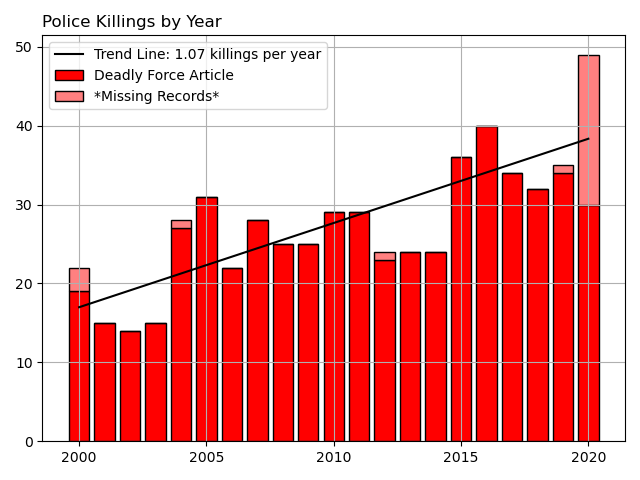

In [133]:
CA_Total=Data.CA_PoliceKillings['PROV'].count()
print('Total Police Killings in Canada: Jan 2000 - June 2020: '+str(CA_Total.sum()))
ByYear=Data.CA_PoliceKillings.resample('YS').count()['PROV']


print(ByYear.max())

CBC_Article = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['Data Source']=='CBC Deadly Force Article'].resample('YS').count()['PROV']
Missing = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['Data Source']!='CBC Deadly Force Article'].resample('YS').count()['PROV']


# print(ByYear.index,ByYear.values)

LR = stats.linregress(ByYear.index.year,ByYear.values)
print(LR)


fig,ax=plt.subplots(1,1)
ax.set_title('Police Killings by Year',loc='left')
ax.bar(CBC_Article.index.year,CBC_Article.values,
       color=[1,0,0],edgecolor='k',label='Deadly Force Article')
ax.bar(Missing.index.year,Missing.values,bottom = CBC_Article.values,
       color=[1,0.5,0.5],edgecolor='k',label='*Missing Records*')
# ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k',label='Total Jan-Nov')
ax.plot(ByYear.index.year,ByYear.index.year*LR[0]+LR[1],
        color='k',label = 'Trend Line: '+str(np.round(LR[0],2))+' killings per year')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_Trendline.png')

# 2) Age distribution of victims

Histograms show the shape and spread of a dataset.
* Here we see the age distribution of victims in 5 year increments.
    * The youngest was 15 and the oldest was 77
    * The mean age is 35.6, the standard deviation is 11.6
* The histogram shows us that the age is slightly skewed towards older ages
    * The distribution has a tail

<IPython.core.display.Javascript object>


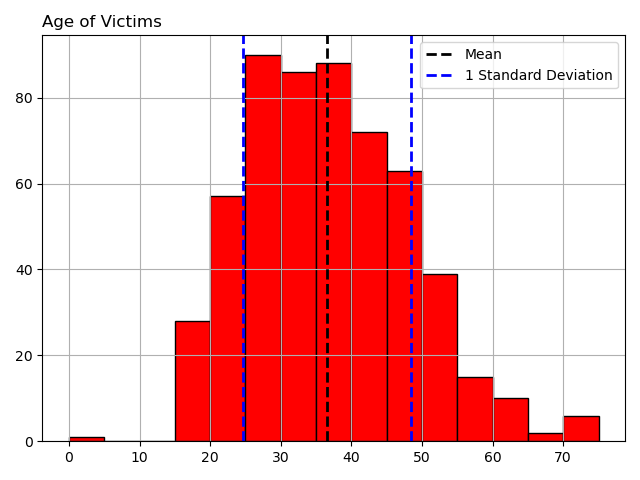

In [134]:
# print(Data.CA_PoliceKillings['AGE'].describe())
# print(Data.CA_PoliceKillings['AGE'].min())
fig,ax=plt.subplots(1,1)
Data.CA_PoliceKillings['AGE'].hist(bins = np.arange(0,80,5),color=[1,0,0],edgecolor='k',ax=ax)
plt.axvline(Data.CA_PoliceKillings['AGE'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
plt.axvline(Data.CA_PoliceKillings['AGE'].mean()+Data.CA_PoliceKillings['AGE'].std(), 
            color='b', linestyle='dashed', linewidth=2,label='1 Standard Deviation')
plt.axvline(Data.CA_PoliceKillings['AGE'].mean()-Data.CA_PoliceKillings['AGE'].std(), 
            color='b', linestyle='dashed', linewidth=2)
# plt.axvline(Data.CA_PoliceKillings['AGE'].quantile(.25), color='b', linestyle='dashed', linewidth=1)
# plt.axvline(Data.CA_PoliceKillings['AGE'].quantile(.25), color='b', linestyle='dashed', linewidth=1)
ax.set_title('Age of Victims',loc='left')
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_AgeHist.png')


# 3) What type of weapon (if any) did the victim have?
* Nearly 30% of victims were unarmed.
    * Note - Being Armed is does not justify any individual police killing.
    * However, in aggregate a higher number of killings of unarmed people can indicate a predisposition towards excessive use of force.

<IPython.core.display.Javascript object>


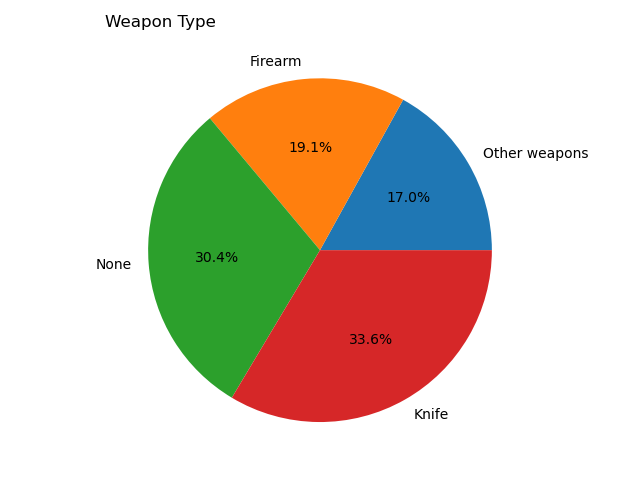

In [135]:
fig,ax=plt.subplots(1,1)
ax.set_title('Weapon Type',loc='left')
Weaopn_Type=Data.CA_PoliceKillings.groupby('ARMED TYPE').count()['AGE'].sort_values()
ax.pie(Weaopn_Type.values,labels=Weaopn_Type.index,
    autopct='%1.1f%%')
plt.tight_layout()
plt.savefig('Content/CA_Weapon.png')

In [136]:
print(Data.CA_PoliceKillings.loc[((Data.CA_PoliceKillings.PROV=='QC') & (Data.CA_PoliceKillings.index.year == 2019))])

                 DATE  NAME FIRST  NAME LAST NAME MIDDLE NICKNAME   AGE  \
DATE                                                                      
2019-03-30 2019-03-30  Jean-Louis    D'amour         NaN      NaN  77.0   
2019-06-28 2019-06-28       Denis  Chalifoux         NaN      NaN  50.0   
2019-07-05 2019-07-05       Sandy      Alaku         NaN      NaN  48.0   

           GENDER        RACE PROV                          POLICE SERVICE  \
DATE                                                                         
2019-03-30   Male     Unknown   QC                        Sûreté du Québec   
2019-06-28   Male     Unknown   QC  Service de police de la Ville de Laval   
2019-07-05   Male  Indigenous   QC           Kativik Regional Police Force   

           Second Third CAUSE DEATH ARMED TYPE PICTURE SOURCE  \
DATE                                                            
2019-03-30    NaN   NaN       Other       None            NaN   
2019-06-28    NaN   NaN     Unknown   

In [137]:
# Data.CA_PoliceKillings.RACE.fillna('Unknown',inplace=True)
Cat = 'RACE'
Departments=Data.CA_PoliceKillings.groupby(['POLICE SERVICE','PROV',Cat]).count()['SUMMARY'].unstack()
Departments=Departments.reset_index().set_index('POLICE SERVICE')
Departments=Departments.fillna(value=0)

Departments['Total'] = Departments[Data.CA_PoliceKillings[Cat].unique()].sum(axis=1)

Departments['NAME']=Departments.index
Departments['NAME']=Departments['NAME'].str.replace(' Department','')
Departments['NAME']=Departments['NAME'].str.replace(' Services','')
Departments['NAME']=Departments['NAME'].str.replace(' Service','')
Departments['NAME']=Departments['NAME'].str.replace(' Force','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de la Ville de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de la sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de police de ','')
Departments['NAME']=Departments['NAME'].str.replace('Régie intermunicipale de police ','')
Departments['NAME']=Departments['NAME'].str.replace('Service de sécurité publique de ','')
Departments['NAME']=Departments['NAME'].str.replace('Sécurité publique de ','')

Departments['City']=Departments['NAME'].str.replace('Ontario Provincial Police','')
Departments['City']=Departments['City'].str.replace(' Police','')
Departments['City']=Departments['City'].str.replace('RCMP','')
Departments['City']=Departments['City'].str.replace('Sûreté du Québec','')
Departments['City']=Departments['City'].str.replace(' Regional','')
Departments['City']=Departments['City'].str.replace('Royal Newfoundland Constabulary','')
Departments['City']=Departments['City'].str.replace(' Community','')
Departments['City']=Departments['City'].str.replace('South Coast British Columbia Transit Authority','')
Departments['City']=Departments['City'].str.replace("l'agglomération de ",'')
Departments['City']=Departments['City'].str.replace('du ','')

Departments['TYPE']='Municipal/Regional'
# Departments.loc[Departments.index.str.contains('Regional')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Toronto')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains("Service de police de l'agglomération de ")==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Transit Authority Police Service')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Régie intermunicipale de police')==True,'TYPE']='Regional'
# Departments.loc[Departments.index.str.contains('Service de police de la Ville de Montréal')==True,'TYPE']='Regional'
Departments.loc[Departments.index.str.contains('RCMP')==True,'TYPE']='RCMP'
Departments.loc[Departments.index.str.contains('Ontario Provincial Police')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('OPP')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Sûreté du Québec')==True,'TYPE']='Provincial'
Departments.loc[Departments.index.str.contains('Royal Newfoundland Constabulary')==True,'TYPE']='Provincial'

writer = pytablewriter.MarkdownTableWriter()
writer.table_name = "Deadliest Police Departments in Canada"
writer.header_list = ['Rank',"Department", "Province", "Killings"]
TB = Departments.loc[Departments['Total']>=10].sort_values(by='Total',ascending=False).reset_index()#[0:10]
writer.value_matrix = [[index+1,value['POLICE SERVICE'],value['PROV'],value['Total']]for index,value in TB.iterrows()]
# list(Departments.groupby('TYPE').count()['NAME'])
#     ["1", "AD", "Europe/Andorra"],
#     ["2", "AE", "Asia/Dubai"],
#     ["3", "AF", "Asia/Kabul"],
#     ["4", "AG", "America/Antigua"],
#     ["5", "AI", "America/Anguilla"],
# ]
# print(Departments.head())
writer.write_table()

print(Departments['Total'].count())
print(Departments.loc[Departments['Total']>=10,'Total'].sum())
print(Departments.loc[Departments['Total']>=10,'Total'].count())

print(Departments.loc[Departments['Total']>=10,'Total'].sum()/CA_Total.sum())

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total'])

print(Departments.loc[Departments.index == 'RCMP'].sum()['Total']/CA_Total.sum())

# print(80/CA_Total.sum())


# Deadliest Police Departments in Canada
|Rank|               Department                |Province|Killings|
|---:|-----------------------------------------|--------|-------:|
|   1|RCMP                                     |BC      |      80|
|   2|Toronto Police Service                   |ON      |      57|
|   3|RCMP                                     |AB      |      36|
|   4|Service de police de la Ville de Montréal|QC      |      36|
|   5|Sûreté du Québec                         |QC      |      36|
|   6|Ontario Provincial Police                |ON      |      33|
|   7|Edmonton Police Service                  |AB      |      28|
|   8|Calgary Police Service                   |AB      |      26|
|   9|Vancouver Police Department              |BC      |      24|
|  10|Winnipeg Police Service                  |MB      |      21|
|  11|Peel Regional Police                     |ON      |      16|
86
393.0
11
0.6764199655765921
156.0
0.2685025817555938


In [138]:
from geopy.geocoders import MapBox
import geopandas as gpd
api_key="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

geolocator = MapBox(api_key=api_key)

# print(Departments)

Departments['Lat']=np.nan
Departments['Lon']=np.nan
Departments['Geocoding_notes']=''

for index,Service in Departments.sort_values(by='Total',ascending=False).iterrows():
    try:
        if Service.TYPE=='Municipal/Regional':
            Point = geolocator.geocode(Service.NAME+', '+Service.City+', '+Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
            Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
        else:
            Point = geolocator.geocode(Data.can_province_names[Service.PROV]+', Canada')#,exactly_one=False)
            Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),['Lat','Lon']]=[Point.latitude,Point.longitude]
    except:
        Departments.loc[((Departments.NAME==Service.NAME)&(Departments.PROV==Service.PROV)),'Geocoding_notes']='Geocoding Failed'
        pass



Departments_GPD = gpd.GeoDataFrame(Departments,
    geometry=gpd.points_from_xy(Departments.Lon,
                                Departments.Lat
                               ) )

# Now we can assign a CRS
WGS_1984={'init' :'epsg:4326'}
Departments_GPD.crs = WGS_1984
Departments_GPD = Departments_GPD.to_crs(Data.CA.crs)
print('Done')

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Done


In [139]:
print(Departments.loc[Departments['Geocoding_notes']=='Geocoding Failed'])

Empty DataFrame
Columns: [PROV, Arab, Asian, Black, Indigenous, Latin American, South Asian, Unknown, Visible minority, n.i.e, White, Total, NAME, City, TYPE, Lat, Lon, Geocoding_notes, geometry]
Index: []


In [140]:
# from geopy.geocoders import MapBox
import folium
# # from IPython.display import clear_output

# api_key = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A"

def plot_point(Map,X,Y,Popup_Text,Color='olive',Radius=5,Opacity=.75,LineColor='black',LineWidth=.15):
    folium.CircleMarker(
        # The coordiatnates
        location=[X,Y],
        # Text description
        popup=Popup_Text,
        # sets the fill color for the point
        fill_color=Color,
        # Size of the marker
        radius=Radius,
        # Opacity of the circle
        fill_opacity = Opacity,
        # Sets the line color for the edge
        color=LineColor,
        # Width of the border line
        line_weight=LineWidth,
    ).add_to(Map)

Scale,Offset=.5,1
    
Final_Map = folium.Map(
    location=[60,-91.5],
    zoom_start=3,
    tiles='Stamen Toner'
)

group0 = folium.FeatureGroup(name='RCMP')
group1 = folium.FeatureGroup(name='Provincial Police Forces')
group2 = folium.FeatureGroup(name='Municipal/Regional Police Forces')
Cats=Data.CA_PoliceKillings['RACE'].unique()
for index, row in Departments_GPD.iterrows():
#     if row['geocoding_Notes'] != 'Geocoding Failed':
        
        # ''' indicates we're wrting multiline strings
        # We'll write the header and the top row of the table
        popuptext='''<body> <h2>'''+index+'''</h2> 
                    <table style="width:100%">
                    <tr>
                    <th>Race</th>
                    <th>Number of Killings &nbsp </th>
                    <th>Percentage of Total</th>
                    </tr>
                     '''
        
        # We'll sort each row by race so the largest appears at the top of the table
        Sorted = row[Cats].sort_values(ascending=False)
        for i,v in zip(Sorted.index,Sorted.values):
            if (np.isnan(v)==False) and (v>0):
                if np.isnan(v)==False:
                    # If the value for a race exists, we'll add it to the table
                    popuptext+= '''<tr>
                                <td>'''+i+''' &nbsp </td>
                                <td>'''+str(int(v))+'''</td>
                                <td>'''+str(int(v/row['Total']*100))+'''%</td>
                                </tr>'''
    #         We'll add row at the bottom of the table with the total


        popuptext+='''<tr>
                      <th>Total </th>
                      <th>'''+str(row['Total'])+'''</th>
                      <th> </th>
                      </tr>'''
        
        # We'll convert the text tot html
        test = folium.Html(popuptext, script=True)
#         folium.
        
        # This defines the parameters for the popup text box
        popup = folium.Popup(test, max_width=400,min_width=300)
        
#         # Now we can send the popup to the CircleMarker
        if row['TYPE']=='RCMP':
            plot_point(Map=group0,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#FF0000',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
            
        elif row['TYPE']=='Provincial':
            plot_point(Map=group1,
                       X=row.Lat,#['latitude'],
                       Y=row.Lon,#['longitude'],
                       Popup_Text=popup,
                       # This is hexcode for the official red of Canada
                       Color='#9400D3',
                       # We'll scale the radius by the number of killings + 2
                       Radius=(row['Total'])*Scale+Offset,
                      )
        else:
            plot_point(Map=group2,
                   X=row.Lat,#['latitude'],
                   Y=row.Lon,#['longitude'],
                   Popup_Text=popup,
                   # This is hexcode for the official red of Canada
                   Color='#0000ff',
                   # We'll scale the radius by the number of killings + 2
                   Radius=(row['Total'])*Scale+Offset,
                  )
group0.add_to(Final_Map)


group2.add_to(Final_Map)


group1.add_to(Final_Map)
    
folium.LayerControl().add_to(Final_Map)
    
Final_Map.save('Content/PoliceViolenceIncidents.html')
Final_Map


# 5) The racial breakdown of police killings.
* The majority of police killings are white people
    * The second largest demographic is "Unknown", which in most cases means the this information was not recorded by the police.  Since this data was collected and reported by a third party rather through a central database, information is missing.  This information should be mandatory for police departments to collect and publish.
* Demographic groups are not evenly represented in the populations
    * Canada is about 73.4% White while its only 4.7% Indigenous and 3.4% Black


0.034096332333932486
                                0
Black                     1198545
Asian                     3216380
Indigenous                1673780
Unknown                         0
White                    25803358
Visible minority, n.i.e    364460
South Asian               1924640
Arab                       523235
Latin American             447330


<IPython.core.display.Javascript object>


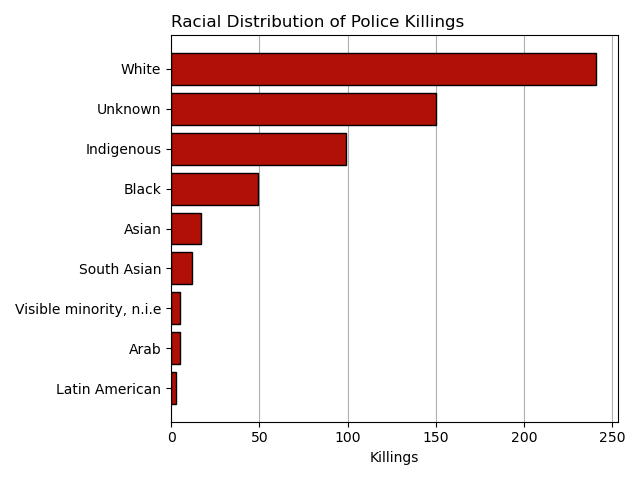

                         PROV
RACE                         
Latin American              3
Arab                        5
Visible minority, n.i.e     5
South Asian                12
Asian                      17
Black                      49
Indigenous                 99
Unknown                   150
White                     241


<IPython.core.display.Javascript object>


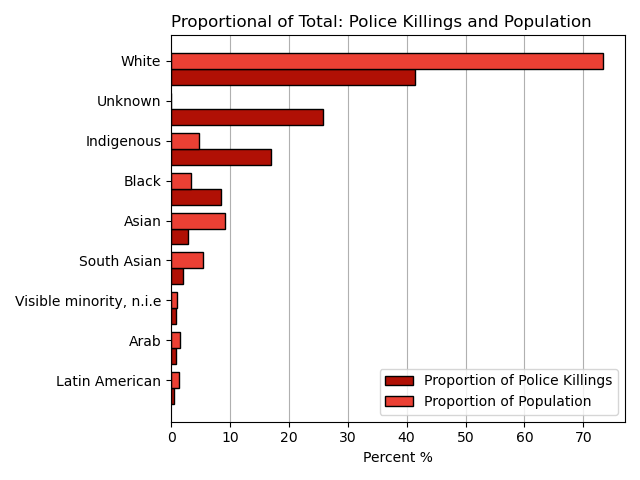

                             PROV         0
RACE                                       
Latin American           0.005164  0.012726
Arab                     0.008606  0.014885
Visible minority, n.i.e  0.008606  0.010368
South Asian              0.020654  0.054752
Asian                    0.029260  0.091500
Black                    0.084337  0.034096
Indigenous               0.170396  0.047616
Unknown                  0.258176  0.000000
White                    0.414802  0.734057


<IPython.core.display.Javascript object>


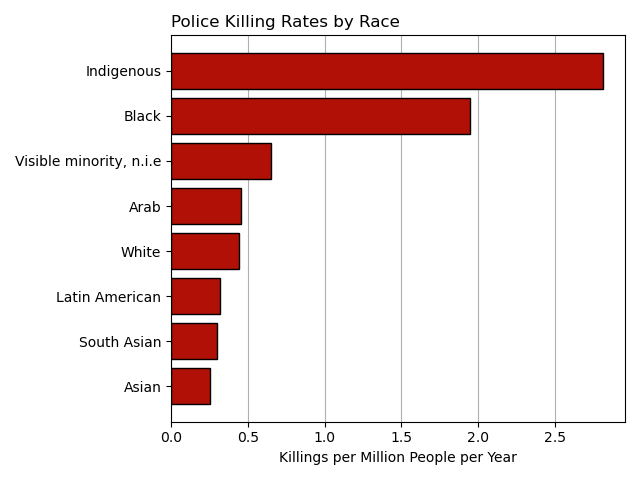

                         PROV         0      Norm
RACE                                             
Asian                      17   3216380  0.251688
South Asian                12   1924640  0.296902
Latin American              3    447330  0.319355
White                     241  25803358  0.444756
Arab                        5    523235  0.455045
Visible minority, n.i.e     5    364460  0.653282
Black                      49   1198545  1.946805
Indigenous                 99   1673780  2.816550
0.7870641997078114
581


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in true_divide


In [141]:
print(Data.CA.sum()['Black']/Data.CA.sum()['Total'])

Races = (Data.CA_PoliceKillings['RACE'].unique())
Pop = Data.CA[Races].sum().to_frame()
print(Pop)
# print(Data.CA[Data.CA_PoliceKillings['RACE'].unique()])

fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)
ax.set_title('Racial Distribution of Police Killings',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=ByRace.to_frame()
# ByRace = ByRace.join(Pop/Pop.sum(),lsuffix='_Pop')
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
ax.barh(np.arange(ByRace.index.shape[0]),ByRace['PROV'].values,color='#b01005',edgecolor='k',
        height=.8,label='Proportion of Police Killings',zorder=2)
# ax.barh(np.arange(ByRace.index.shape[0]),ByRace[0].values,color='#eb4034',edgecolor='k',
#         height=.4,label='Proportion of Population')
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.set_xlabel('Killings')
# ax.legend()
plt.tight_layout()
plt.savefig('Content/CA_Race.png')



fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Proportional of Total: Police Killings and Population',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=(ByRace/ByRace.sum()).to_frame()
ByRace = ByRace.join(Pop/Pop.sum(),lsuffix='_Pop')
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values*100,color='#b01005',edgecolor='k',
        height=.4,label='Proportion of Police Killings',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace[0].values*100,color='#eb4034',edgecolor='k',
        height=.4,label='Proportion of Population',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.set_xlabel('Percent %')
ax.legend()
plt.tight_layout()

plt.savefig('Content/CA_Race_Proportional.png')


fig,ax=plt.subplots(1,1)
ax.grid(axis='x',zorder=0)

ax.set_title('Police Killing Rates by Race',loc='left')
ByRace=Data.CA_PoliceKillings.groupby('RACE').count()['PROV'].sort_values()
ByRace=ByRace.to_frame()
ByRace = ByRace.join(Pop,lsuffix='_Pop')
ByRace['Norm']=ByRace['PROV'].values/ByRace[0].values*1e6/21
ByRace=ByRace.sort_values(by='Norm')[:-1]
print(ByRace)
# ByRace[['PROV',0]].plot(kind='barh')
# ax.barh(np.arange(ByRace.index.shape[0])-.4,ByRace['PROV'].values,color='#b01005',edgecolor='k',
#         height=.4,label='Proportion of Police Killings',zorder=2)
ax.barh(np.arange(ByRace.index.shape[0]),ByRace['Norm'],color='#b01005',edgecolor='k',
        height=.8,label='Proportion of Population',zorder=2)
ax.set_yticks(np.arange(ByRace.index.shape[0]))
ax.set_yticklabels(ByRace.index)
ax.set_xlabel('Killings per Million People per Year')
# ax.legend()
plt.tight_layout()

plt.savefig('Content/CA_Race_Normalized.png')



print(CA_Total.sum()/Data.CA.Total.sum()/21*1e6)
# print(Data.CA.Total.sum())
print(CA_Total.sum())

In [142]:
Municipal_Deparments = Departments_GPD.loc[Departments_GPD['TYPE']=='Municipal/Regional']
Other_Deparments = Departments_GPD.loc[Departments_GPD['TYPE']!='Municipal/Regional']

# print(Municipal_Deparments)

Temp = (gpd.sjoin(Data.Municipal_Boundaries,Municipal_Deparments,lsuffix='Pop',rsuffix='Dept_Killings')).set_index('NAME')
# Temp['Indigenous']
for d in ['White','Indigenous','Black','Arab','Total']:
    Temp[d+'_Rate'] = Temp[d+'_Dept_Killings'] / Temp[d+'_Pop'] * 1e6 /21
# d = 'Total'
# print(Temp[['Indigenous_Rate','Indigenous_Killings',
#             'Black_Rate','Black_Killings',
#             'Total_Rate','Total_Killings']].sort_values(by=d+'_Killings')[-10:])

# print(Temp.columns)
Temp2 = (gpd.sjoin(Data.CA,Other_Deparments,lsuffix='Pop',rsuffix='Dept_Killings')).set_index('NAME')
# Temp['Indigenous']
for d in ['White','Indigenous','Black','Arab','Total']:
#     print(Temp[d+'_Dept_Killings'] , Temp[d+'_Pop'])
    Temp2[d+'_Rate'] = Temp2[d+'_Dept_Killings'] / Temp2[d+'_Pop'] * 1e6 /21
#     print('??')
# # d = 'Total'
# print(Temp[['PROV','Indigenous_Rate','Total_Dept_Killings']].sort_values(by='Indigenous_Rate'))

Temp.columns
Temp3=Temp[['Indigenous_Rate','Indigenous_Dept_Killings',
            'Black_Rate','Black_Dept_Killings',
            'White_Rate','White_Dept_Killings',
            'Arab_Rate','Arab_Dept_Killings',
            'Total_Rate','Total_Dept_Killings']].append(Temp2[['PROV','Indigenous_Rate','Indigenous_Dept_Killings',
            'Black_Rate','Black_Dept_Killings',
            'White_Rate','White_Dept_Killings',
            'Arab_Rate','Arab_Dept_Killings',
            'Total_Rate','Total_Dept_Killings']])
print(Temp3.sort_values(by='Total_Dept_Killings')[-10:])
# print(Temp[['Indigenous_Rate','Indigenous_Killings',
#             'Black_Rate','Black_Killings',
#             'Total_Rate','Total_Killings']].sort_values(by=d+'_Killings')[-10:])
# print((Temp['Indigenous_Killings']/Temp['Indigenous_Pop']*1e6/21).sort_values().dropna()[-10:])

                           Indigenous_Rate  Indigenous_Dept_Killings  \
NAME                                                                   
Winnipeg Police                   7.907795                      14.0   
Vancouver Police                  3.425831                       1.0   
Calgary Police                    4.059018                       3.0   
Edmonton Police                   4.735387                       5.0   
Ontario Provincial Police         0.508757                       4.0   
Sûreté du Québec                  0.000000                       0.0   
RCMP                              1.657019                       9.0   
Montréal                          0.000000                       0.0   
Toronto Police                    2.064559                       1.0   
RCMP                              2.287812                      13.0   

                           Black_Rate  Black_Dept_Killings  White_Rate  \
NAME                                                         

In [143]:
print(Departments['Total'].sort_values()[-10:])

POLICE SERVICE
Winnipeg Police Service                      21.0
Vancouver Police Department                  24.0
Calgary Police Service                       26.0
Edmonton Police Service                      28.0
Ontario Provincial Police                    33.0
RCMP                                         36.0
Sûreté du Québec                             36.0
Service de police de la Ville de Montréal    36.0
Toronto Police Service                       57.0
RCMP                                         80.0
Name: Total, dtype: float64


In [144]:
print(ByRace)
from scipy.stats import chisquare
print(ByRace.index)
# R = ['Indigenous','White','Black','Arab','Asian']
R = ByRace.index.values#.drop('Unknown').values
Dept = ['Winnipeg Police Service','Vancouver Police Department','Toronto Police Service','Calgary Police Service','Edmonton Police Service']
City = ['Winnipeg','Vancouver','Toronto','Calgary','Edmonton']
FOBS = []
FEXP = []
for D,C in zip(Dept,City):
    F_obs = Departments_GPD.loc[Departments_GPD.index == D,R].values.flatten()
    F_exp = Data.Municipal_Boundaries.loc[Data.Municipal_Boundaries['Name'] == C,R].values.flatten()
    F_exp = F_exp/F_exp.sum()*Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']==D,'GENDER'].count()#F_obs.sum()
    
    FOBS.append(F_obs)
    FEXP.append(F_exp)
#     print(F_exp)
    res = chisquare(F_obs, f_exp=F_exp)
    print(C,F_obs.sum(),res[1])

# print(Data.CA['PREABBR'])
# print(Data.CA['PREABBR'])
# Data.CA.head()
P = Departments_GPD['PROV'].unique()
# P2 = ['B.C.','B.C.']

R2 = [r+'_Killings'for r in R]
for p in P:
    try:
        F_obs = Data.CA.loc[((Data.CA.index ==  p)),
                                    R2].fillna(0).values.flatten()
        F_exp = Data.CA.loc[Data.CA.index== p,R].fillna(0).values.flatten()
        F_exp = F_exp/F_exp.sum()*F_obs.sum()
        FOBS.append(F_obs)
        FEXP.append(F_exp)
#         print(F_obs,F_exp)
        res = chisquare(F_obs, f_exp=F_exp)
        print(p,F_obs.sum(),res[1])
        
    except:
        pass

# print(FOBS,FEXP)
# print(chisquare(np.array(FOBS).T, f_exp=np.array(FEXP).T))
# print()

F_obs=Data.CA[R2].fillna(0).sum().values
F_exp=Data.CA[R].fillna(0).sum().values

F0 = F_exp.tolist()
print(F_exp)
F0.append(F_exp.sum())
F0.append(0)
F_exp = F_exp*(Data.CA_PoliceKillings.count().RACE/F_exp.sum())

print()
res = chisquare(F_obs, f_exp=F_exp)
print(res)
R = R.tolist()
R.append('Total')

R = np.append(R,'Unknown')

F1 = F_exp.tolist()
F1.append(F_exp.sum())
F1.append(0)
F2 = F_obs.tolist()
F2.append(Data.CA_PoliceKillings.count().RACE)
F2.append(Data.CA['Unknown_Killings'].sum())

from tabulate import tabulate
d = {"By Race": ["Total Population (Millions)", "Expected Distribtuion", "Observed Killings"]}
for i,r in enumerate(R):
    d[r]=[int(F0[i]/1e5)/10,int(F1[i]),int(F2[i])]
df = pd.DataFrame(d).set_index("By Race")
df = df.T.sort_values(by='Total Population (Millions)',ascending=False).T
df.loc[df.index!='Observed Killings','Unknown']='--'


print(tabulate(df.T, tablefmt="pipe", headers="keys"))
print(Data.CA['Total_Killings'].sum()/Data.CA['Total'].sum()*1e6/21)
print(Data.CA['Total_Killings'].sum())
print(Data.CA_PoliceKillings.count())

T = (Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['RACE']=='Unknown'].groupby('POLICE SERVICE').count()['GENDER'].sort_values())

print(T/T.sum())

                         PROV         0      Norm
RACE                                             
Asian                      17   3216380  0.251688
South Asian                12   1924640  0.296902
Latin American              3    447330  0.319355
White                     241  25803358  0.444756
Arab                        5    523235  0.455045
Visible minority, n.i.e     5    364460  0.653282
Black                      49   1198545  1.946805
Indigenous                 99   1673780  2.816550
Index(['Asian', 'South Asian', 'Latin American', 'White', 'Arab',
       'Visible minority, n.i.e', 'Black', 'Indigenous'],
      dtype='object', name='RACE')
Winnipeg 20.0 2.359879704184608e-12
Vancouver 16.0 0.005041533881118799
Toronto 43.0 2.9100745600602817e-10
Calgary 20.0 0.024671854195823437
Edmonton 19.0 0.015548695673114569
BC 83.0 8.747589524290645e-06
ON 136.0 7.001040385844872e-26
QC 79.0 9.89689774142183e-11
NB 5.0 0.01565901751250399
AB 61.0 4.5020522198993826e-10
NS 6.0 0.9736847

### Think about how comparing at the total killings for population groups of very different sizes might impact the way you perceive patterns.  Using this chart, what demographic group do you think is most likely to be killed by the police in Canada?

# 4) Which police departments are responsible for the most killings?
Here are all departments which have killed at least ten people in the last 20 years.
* Provincial police services and large municipal police departments are responsible for the most deaths
* The RCMP serves as the provincial police in eight provinces and the territories.
    * All together, the RCMP is responsible for 34% of deaths 

<IPython.core.display.Javascript object>


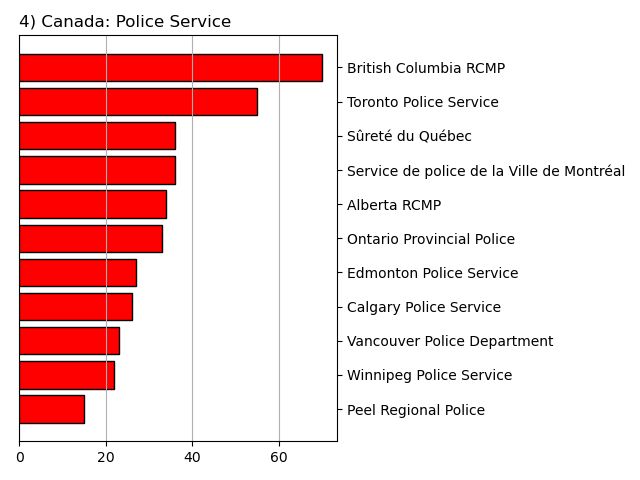

POLICE SERVICE
Peel Regional Police                         0.039788
Winnipeg Police Service                      0.058355
Vancouver Police Department                  0.061008
Calgary Police Service                       0.068966
Edmonton Police Service                      0.071618
Ontario Provincial Police                    0.087533
Alberta RCMP                                 0.090186
Service de police de la Ville de Montréal    0.095491
Sûreté du Québec                             0.095491
Toronto Police Service                       0.145889
British Columbia RCMP                        0.185676
Name: Total, dtype: float64


In [145]:
# print(Data.CA.Total.sort_values()/Data.CA.Total.sum())
ARMED_TYPE=(Data.CA_PoliceKillings.groupby(['POLICE SERVICE','ARMED TYPE']).count()['AGE'].unstack())
# print(ARMED_TYPE)
ARMED_TYPE_RCMP_PROV=(Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']=='RCMP'].groupby(['PROV','ARMED TYPE']).count()['AGE'].unstack())
ARMED_TYPE_RCMP_PROV['Name'] = [Data.can_province_names[x] for x in ARMED_TYPE_RCMP_PROV.index]
ARMED_TYPE_RCMP_PROV['POLICE SERVICE']=ARMED_TYPE_RCMP_PROV['Name']+' RCMP'

ARMED_TYPE_RCMP_PROV=ARMED_TYPE_RCMP_PROV.set_index(ARMED_TYPE_RCMP_PROV['POLICE SERVICE'])
# print(ARMED_TYPE_RCMP_PROV)
# print(ARMED_TYPE)

ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE.index !='RCMP'].append(ARMED_TYPE_RCMP_PROV)


Types = ARMED_TYPE.columns
ARMED_TYPE['Total']=ARMED_TYPE.sum(axis=1)

fig,ax=plt.subplots(1,1)
ax.set_title('4) Canada: Police Service',loc='left')
# ByRace=Data.CA_PoliceKillings.groupby('POLICE SERVICE').count()['AGE'].sort_values()[-10:]
ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='Total')
ax.barh(ARMED_TYPE.index,ARMED_TYPE['Total'].values,color=[1,0,0],edgecolor='k')
# ax.yaxis.set_tick_params(pad=160)
# ax.set_yticklabels(ARMED_TYPE.index, ha = 'left')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.grid(axis='x')
plt.tight_layout()
plt.savefig('Content/CA_PoliceServices.png')


print(ARMED_TYPE['Total']/ARMED_TYPE['Total'].sum())
# fig,ax=plt.subplots(1,1)
# RCMP = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['POLICE SERVICE']=='RCMP'].groupby('PROV').count().sort_values(by='RACE')
# ax.set_title('6) RCMP: By Province',loc='left')
# # ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='Total')
# ax.barh(RCMP.index,RCMP['RACE'].values,color=[1,0,0],edgecolor='k')
# plt.tight_layout()


# Data Normalization

Normalization, is the process of scaling (AKA Normalizing) one number by another.
* For example, we can as the question:
    * Which police departments are most likely to kill an unarmed person?
* We need two pieces of information for each police department
    * A) The total unarmed victims
    * B) The total victims
* We can divide A by B, this will tell us what percentage of each departments victims were unarmed.
* So our normalization calculation would look like:

    
\begin{align}
\ Percent Unarmed & = (\frac{Unarmed Victims}{Total Victims})* 100 \\
\end{align}

This shows different patterns in the data that are easy to overlook when using raw counts
* Nearly half the people killed by BC RCMP did not have a weapon
    * Vancouver Police are the fourth most likely to kill an unarmed person.  Nearly 40% of their victims are unarmed.
    * Killing of unarmed people by police in our region is a severe problem.
    
# This information should be widely known and available.  The RCMP and other Police Services across Canada need to be held accountable.

<IPython.core.display.Javascript object>


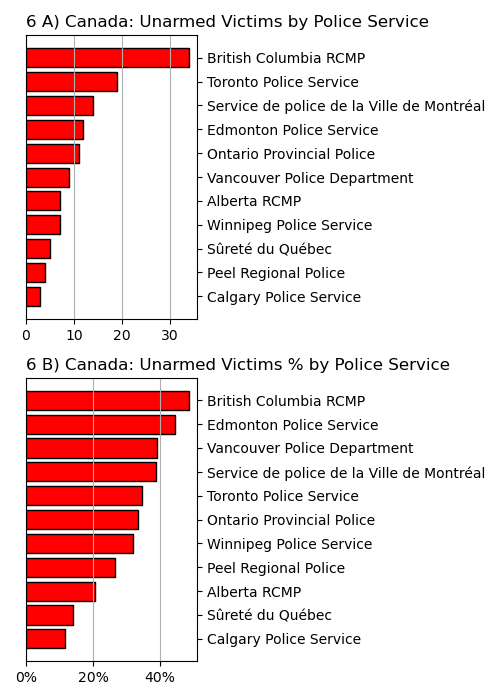

In [146]:
import matplotlib.ticker as mtick
ARMED_TYPE['Unarmed%']=ARMED_TYPE['None']/ARMED_TYPE['Total']*100
ARMED_TYPE = ARMED_TYPE.fillna(0)
fig,ax=plt.subplots(2,1,figsize=(5,7))

ax[0].set_title('6 A) Canada: Unarmed Victims by Police Service',loc='left')
ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='None')
ax[0].barh(ARMED_TYPE.index,ARMED_TYPE['None'].values,color=[1,0,0],edgecolor='k')
ax[0].yaxis.tick_right()
ax[0].grid(axis='x')

ax[1].set_title('6 B) Canada: Unarmed Victims % by Police Service',loc='left')
ARMED_TYPE = ARMED_TYPE.loc[ARMED_TYPE['Total']>10].sort_values(by='Unarmed%')
ax[1].barh(ARMED_TYPE.index,ARMED_TYPE['Unarmed%'].values,color=[1,0,0],edgecolor='k')
ax[1].yaxis.tick_right()
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter())
ax[1].grid(axis='x')
plt.tight_layout()
plt.savefig('Content/CA_UnarmedFraction.png')

<IPython.core.display.Javascript object>


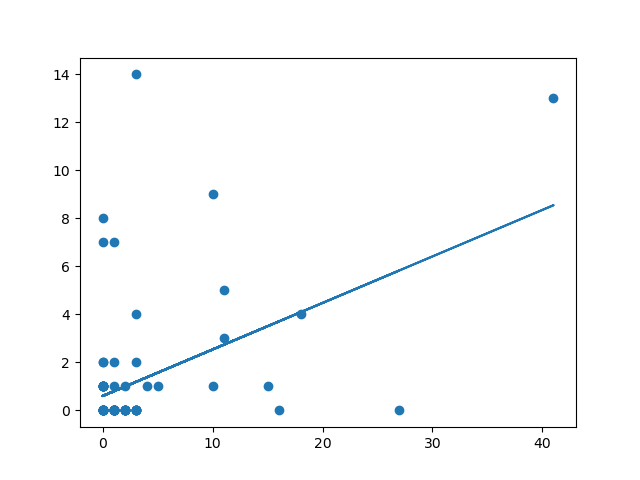

LinregressResult(slope=0.19390880051578122, intercept=0.5983940450722385, rvalue=0.44813068127418326, pvalue=1.5133378914457628e-05, stderr=0.042206097752807266)


In [147]:

plt.figure()
plt.scatter(Departments.White,Departments.Indigenous)
LR = stats.linregress(Departments.White,Departments.Indigenous)
plt.plot(Departments.White,Departments.White*LR[0]+LR[1])
print(LR)

# Questions:

What are some other applications for data normalization?

What metric(s) might you want consider when looking at White number of electric cars in each province to gauge electirc car adoption?

A) Kilometers driven
B) Cars per family
C) Median Income
D) White Population
E) Average Car Price

# The United States Data
 
The United States Data is colected by a colaboration of researchers and data scientists and is availble for download here: https://mappingpoliceviolence.org/

"We believe the data represented on this site is the most comprehensive accounting of people killed by police since 2013. Note that the Mapping Police Violence database is more comprehensive than the Washington Post police shootings database: while WaPo only tracks cases where people are fatally shot by on-duty police officers, our database includes additional incidents such as cases where police kill someone through use of a chokehold, baton, taser or other means as well as cases such as killings by off-duty police."

This is not an official count.
* This dataset is a collection of second hand information in the form of press releases, news articles, etc.
* Some records are incomplete, and the total number of incidents is likely higher than detailed here.

count    8579.000000
mean       36.853596
std        13.127059
min         1.000000
25%        27.000000
50%        35.000000
75%        45.000000
max       107.000000
Name: AGE, dtype: float64


<IPython.core.display.Javascript object>


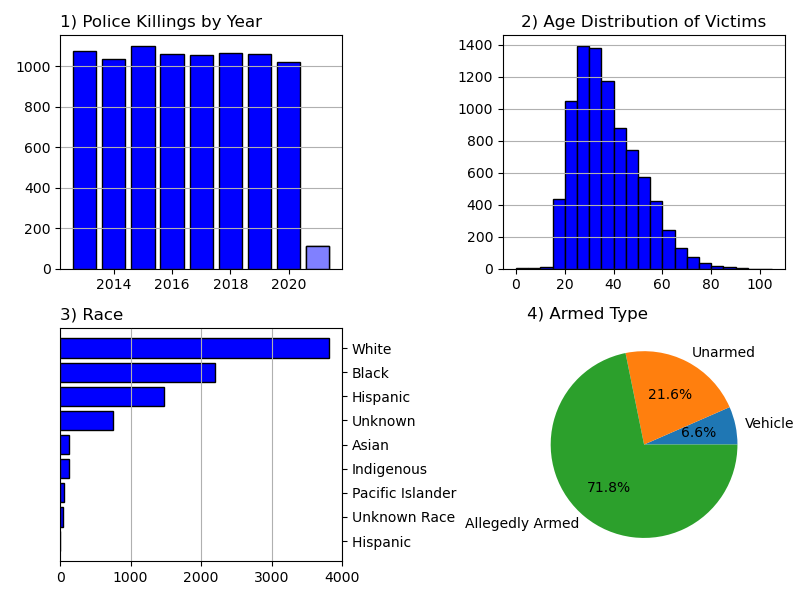

RACE
Hispanic            0.000117
Unknown Race        0.005129
Pacific Islander    0.005712
Indigenous          0.013755
Asian               0.015153
Unknown             0.087889
Hispanic            0.172281
Black               0.255741
White               0.444224
Name: AGE, dtype: float64


In [148]:
US_Total=Data.US_PoliceKillings["State"].count()

print(Data.US_PoliceKillings["AGE"].describe())

fig,ax=plt.subplots(2,2,figsize=(8,6))
ax[0,0].set_title('1) Police Killings by Year',loc='left')
ByYear=Data.US_PoliceKillings.resample('YS').count()['AGE']
ax[0,0].bar(ByYear.index.year,ByYear.values,color=[0,0,1],edgecolor='k')
ax[0,0].bar([2021],[ByYear.values[-1]],color=[.5,.5,1],edgecolor='k')
# plt.tight_layout()

ax[0,0].grid(axis='y')
# plt.savefig('Content/US_ByYear.png')

# fig,ax=plt.subplots(1,1)
ax[1,0].set_title('3) Race',loc='left')
ByRace=Data.US_PoliceKillings.groupby('RACE').count()['AGE'].sort_values()

print(ByRace/ByRace.sum())
ax[1,0].barh(ByRace.index,ByRace.values,color=[0,0,1],edgecolor='k')

ax[1,0].yaxis.tick_right()
ax[1,0].grid(axis='x')

# plt.tight_layout()
# fig,ax=plt.subplots(1,1)
ax[1,1].set_title('4) Armed Type',loc='left')
ByRace=Data.US_PoliceKillings.groupby('Armed/Unarmed Status').count()['AGE'].sort_values()
ax[1,1].pie(ByRace.values,labels=ByRace.index,
    autopct='%1.1f%%')
# plt.tight_layout()



# fig,ax=plt.subplots(1,1)
Data.US_PoliceKillings['AGE'].hist(bins = np.arange(0,110,5),color=[0,0,1],edgecolor='k',ax=ax[0,1])
ax[0,1].set_title('2) Age Distribution of Victims')
ax[0,1].grid(axis='x')
plt.tight_layout()



plt.savefig('Content/US_Data.png')



# Part 2) Comparing to the United States  

There are more police killings in the United States than in Canada

* What factors do we need to look at to compare police killings between Canada and the United States?

* The United States has ten times the population of Canada.  If we don't acount for that, our comparsion wont make any sense
    * The graph below is comparing two countries with very different populations and two datasets with different periods of record.

<IPython.core.display.Javascript object>


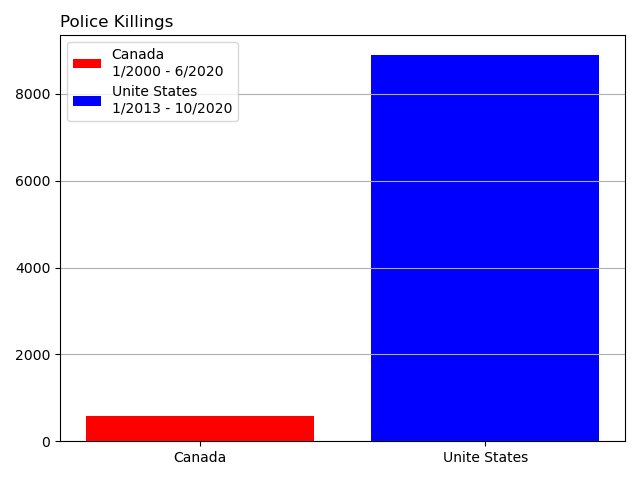

In [149]:

fig,ax=plt.subplots()
ax.bar([0],CA_Total,color=[1,0,0],label='Canada\n1/2000 - 6/2020')
ax.bar([1],US_Total,color=[0,0,1],label='Unite States\n1/2013 - 10/2020')
ax.set_xticks([0,1])
ax.set_xticklabels(['Canada','Unite States'])
ax.set_title('Police Killings',loc='left')
ax.grid(axis='y')
ax.legend()
plt.tight_layout()
plt.savefig('Content/RawComparison.png')

# What to account for

### A) Record Length
The time periods of these datasets are different
We could only look at the time period when they overlap but, but this would require us to ignore some of the data. 
Alternatively, we can calculate the average number of killings per year.
The data are not from the same periods, but they will be on the same time scale, and they will be as inclusive as possible
### B) Population
The Canada has about 35 million residents.  The US has about 327 million.  
To make the datasets directly comparable, we need to normalize by the total population of each country.  This will allow us to calculate the police killing rate
### C) Scale
Dividing by the population would give us the average number of police killings per person per year.  This will be a very small decimal.  Integers (round numbers) are easier to interpret.  We can divide by the population in millions instead.

# Police Killing Rates
* By normalizing, we can more directly compare the patterns between geographic regions with different characteristics (Population) and datasets of different lenghts

<IPython.core.display.Javascript object>


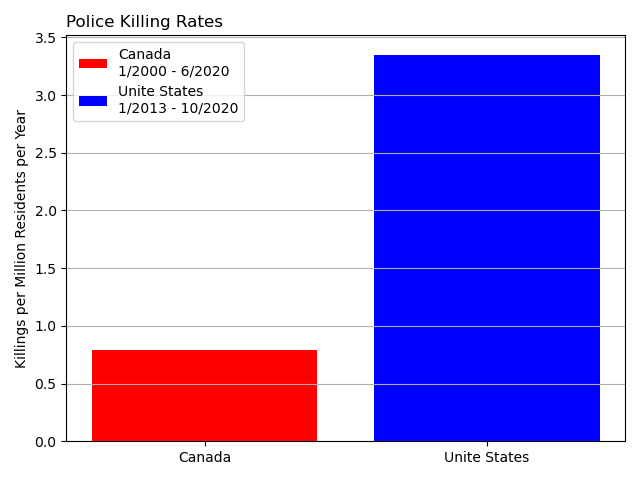

4.243364674519978


In [150]:
CA_Rate = CA_Total /(Data.CA.Total.sum()*Data.CA_Length) * 1e6
US_Rate = US_Total /(Data.US.Total.sum()*Data.US_Length) * 1e6

fig,ax=plt.subplots()
ax.bar([0],CA_Rate,color=[1,0,0],label='Canada\n1/2000 - 6/2020')
ax.bar([1],US_Rate,color=[0,0,1],label='Unite States\n1/2013 - 10/2020')
ax.set_xticks([0,1])
ax.set_xticklabels(['Canada','Unite States'])
ax.set_title('Police Killing Rates',loc='left')
ax.set_ylabel('Killings per Million Residents per Year')
ax.legend()


ax.grid(axis='y')
ax.legend()
plt.tight_layout()
plt.savefig('Content/NormalizedComparison.png')

print(US_Rate/CA_Rate)

# Racial Disparities

Systemic Racism is pervasive on both sides of the border

* The police violence dataset and census for each country use different demographic groupings
    * We'll compare the police killing rates of three demographic groups: White, Black, and Indigenous because they are in both datasets.
        * Whites are the majority in both countries, while black and indigenous people disproportionately impacted by police killings on both sides of the border.
* One Caveat, the race of the victim is unknown for 24% of Canadian and 10% of United States.
    * This adds uncertainty to the comparison.  It also means that the Police Killing Rates by race are underestimated, especially for Canada

# Systemic Racism in Policing

* Scaled, to their respective populations, we can see that Indigenous and Black people are much more likely to be killed by the police than white pople in both Canada and the United States
* The overal rates for each race are higher in the US than Canada
    * However the dispartiy between races is actually greater in Canada than the United States
    
* To show this, we can divide the black and indigenous rates fore each country by the white rate.
    * This will tell us how many times more likely a black or indigenous individual is to be killed by the police than a white individual in each country.
    * We can see that Indigenous and Black Canadians are 5.8 and 4.4 times more likely to be killied by police than a White Canadian
        * These disparities are higher than in the US
            * By this metric, you could suggest that police in Canada may be more racially biased than police in the US

['Black' 'Asian' 'Indigenous' 'Unknown' 'White' 'Visible minority, n.i.e'
 'South Asian' 'Arab' 'Latin American']
['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total

<IPython.core.display.Javascript object>


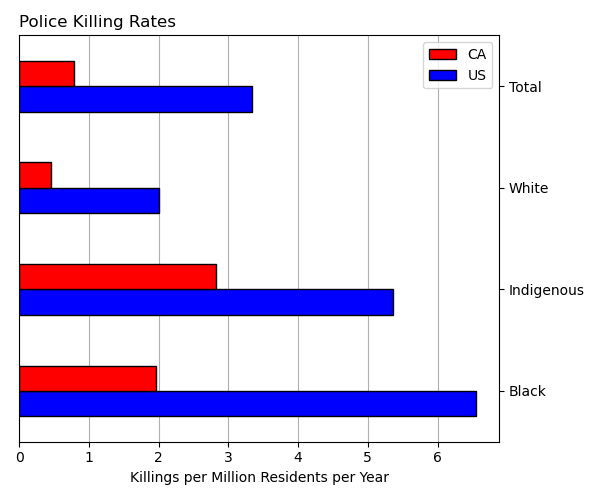

In [151]:
print(Data.CA_PoliceKillings['RACE'].unique())
# print(Data.Combined)

Data.ScaleData(scale=1e6)
print('Police Killing Rates:')
# print(Data.Summary)
Data.Summary = Data.Summary.dropna()
Data.Summary = Data.Summary.loc[Data.Summary.index!='Asian']

fig,ax=plt.subplots(figsize=(6,5))
Data.Summary[['US','CA']].plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder=2)
ax.set_title('Police Killing Rates',loc='left')
ax.set_xlabel('Killings per Million Residents per Year')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])


plt.tight_layout()
plt.savefig('Content/Racial_Comparison.png')


                  US        CA
Black       3.268433  4.377246
Indigenous  2.670622  6.332803


<IPython.core.display.Javascript object>


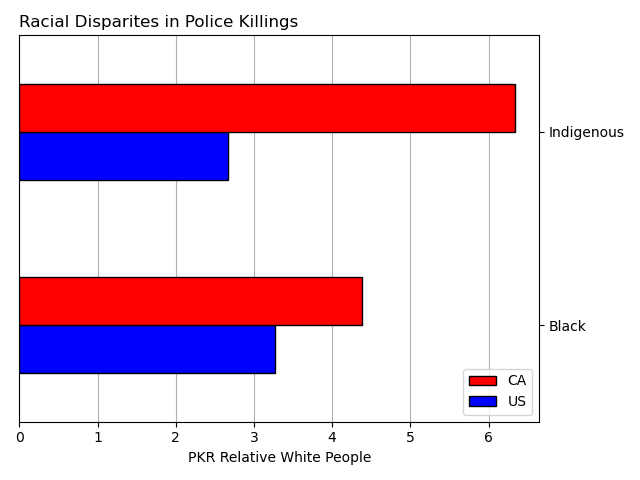

In [152]:
Ratio = Data.Summary.loc[Data.Summary.index=='Black']/Data.Summary.loc[Data.Summary.index=='White'].values
Ratio = Ratio.append(Data.Summary.loc[Data.Summary.index=='Indigenous']/Data.Summary.loc[Data.Summary.index=='White'].values)

print(Ratio)
fig,ax=plt.subplots()
Ratio.plot.barh(color=[[0,0,1],[1,0,0]],edgecolor='k',ax=ax,zorder = 2)
ax.set_title('Racial Disparites in Police Killings',loc='left')
ax.set_xlabel('PKR Relative White People')
ax.yaxis.tick_right()
ax.grid(axis='x',zorder=0)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])


plt.tight_layout()
plt.savefig('Content/Racial_Disparities.png')


# Systemic Racism in Policing is a Canadian Problem

This issue isn't restricted to America, it's pervasive in Canada as well and can not be overlooked. 

* The RCMP were created by Prime Minister John A. Macdonald.  He got the idea for the Mounties from the Royal Irish Constabulary, a paramilitary police force the British created to keep the Irish under control.  Initially called the "North West Mounted Rifles", their primary purpose to clear Indigenous people off their land.  The name was changed to "North-West Mounted Police" because officials in the United States raised concerns that an armed force along the border was a prelude to a military buildup.  This organization was renamed the Royal Canadian Mounted Police in 1904.

# Questions
* Which country is displaying normalized data?
A) Canada
B) The United States
C) Both
D) Neither

In [153]:
print(Data.Combined)

    Black_Killings  Black_Rate   Black  Asian_Killings  Asian_Rate   Asian  \
NL             NaN    0.000000    2350             NaN    0.000000    4400   
PE             NaN    0.000000     825             NaN    0.000000    3920   
NS             NaN    0.000000   21910             NaN    0.000000   17015   
NB             NaN    0.000000    6995             NaN    0.000000    9780   
QC            10.0    1.496220  319230             NaN    0.000000  242275   
..             ...         ...     ...             ...         ...     ...   
ME             1.0    6.492702   18954             NaN    0.000000   15683   
HI             1.0    4.344666   28325             3.0    0.690744  534479   
NH             NaN    0.000000   23432             NaN    0.000000   36048   
AZ            33.0   12.074294  336340             NaN    0.000000  237873   
RI             3.0    5.218279   70749             NaN    0.000000   36064   

    Indigenous_Killings  Indigenous_Rate  Indigenous  Unknown_K

C:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<IPython.core.display.Javascript object>


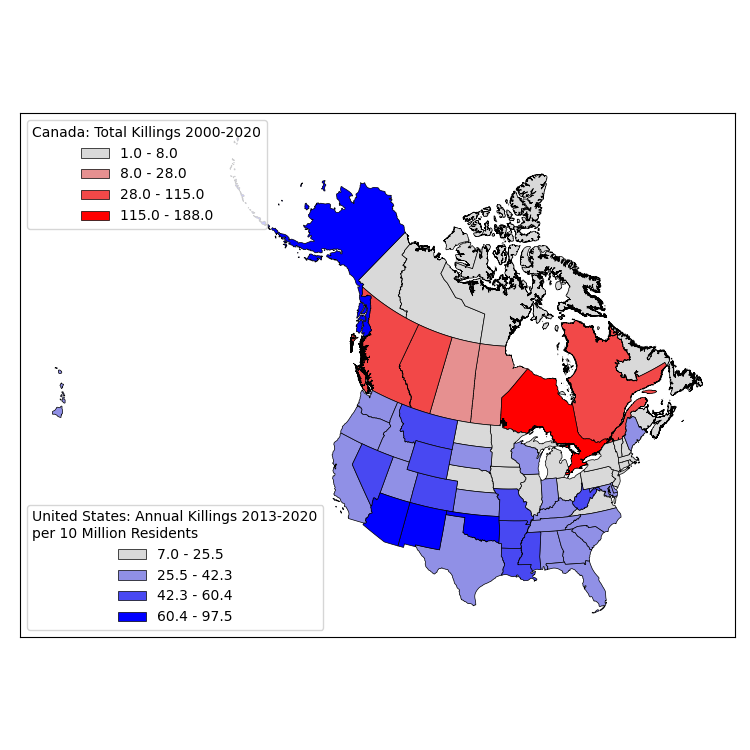

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: UserWarning: Legend does not support Text(0, 0, 'Canada') instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


In [154]:
Rate = 'Total'
n_classes=4
Data.Breaks(column='Total_Killings',classes=n_classes,Manual_Bins=[1,4,7,91,175])
Data.US=Data.US.to_crs(Data.CA.crs)

labels=Data.CA[Rate+'_Killings_NB'].unique().sort_values()
colors = []
Grey = .85
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
CA_Color = {key:value for key,value in zip(labels,colors)}
# print(CA_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = [matplotlib.text.Annotation('Canada',(0,0))]
for i,klass in enumerate(Data.CA[Rate+'_Killings_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':CA_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.CA_jenks[i],1))+' - '+str(np.round(Data.CA_jenks[i+1],1))}
    if Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].count()['PRNAME']>0:
        Data.CA.loc[Data.CA[Rate+'_Killings_NB']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))

Data.ScaleData(scale=1e7)
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])

labels=Data.US[Rate+'_Rate_NB'].unique().sort_values()
colors = []
for c in range(n_classes):
    colors.append(matplotlib.colors.to_hex([Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey),Grey+(c/(n_classes-1)*(1-Grey))]))
US_Color = {key:value for key,value in zip(labels,colors)}

US_Patches = []
# US_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'United States'}))
for i,klass in enumerate(Data.US[Rate+'_Rate_NB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':US_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.US_jenks[i],1))+' - '+str(np.round(Data.US_jenks[i+1],1))}
    Data.US.loc[Data.US[Rate+'_Rate_NB']==klass].plot(
        ax=ax,
        **kwargs
             )
    US_Patches.append(mpatches.Patch(**kwargs))
first_legend = plt.legend(handles=CA_Patches, loc='upper left',
      title='Canada: Total Killings 2000-2020')

# Add the legend manually to the current Axes.
plt.gca().add_artist(first_legend)

# Create another legend for the second line.
ax.legend(handles=(US_Patches), loc='lower left',
      title='United States: Annual Killings 2013-2020\nper 10 Million Residents')
    
# ax.legend(handles={'PKR':Patches},) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_title('Police Killings')

plt.tight_layout()
plt.savefig('Content/IsItNormalalized_Map.png',bbox_inches='tight')

# Part 3) Histograms, Data Classification, & Cloropleth Mapping


# Rates by Province/State

Police Killing Rates vary by administrative divisions, e.g. (State/Province)
* If we want to compare rates the first step is to look at histograms.
* A Histogram shows us the frequency distribution of a given variable
    * Data is grouped into a set of bins and counted


<IPython.core.display.Javascript object>


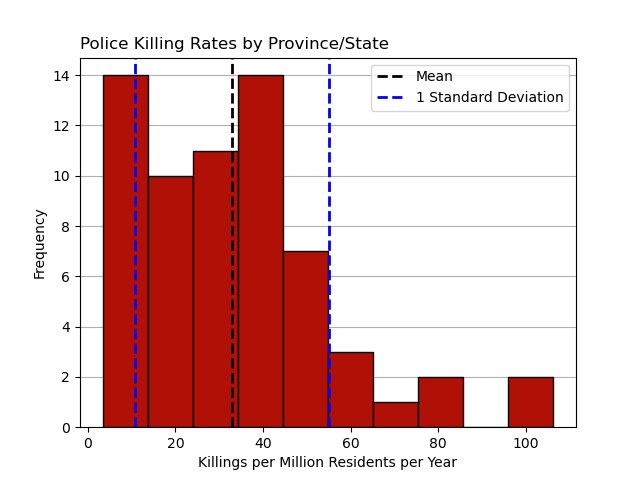

In [155]:
Rate = 'Total'
n_classes=4
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,.5,1,2,10])
# plt.figure()
import numpy as np
fig,ax=plt.subplots()#1,2)
# print(Data.CA['Total_Killings'].describe())
Data.Combined['Total_Rate'].hist(ax=ax,color='#b01005',edgecolor='k',zorder=2)
ax.grid(axis='x')
ax.set_ylabel('Frequency')
ax.set_xlabel('Killings per Million Residents per Year')
ax.set_title('Police Killing Rates by Province/State',loc='left')
ax.axvline(Data.Combined['Total_Rate'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
ax.axvline(Data.Combined['Total_Rate'].mean()+Data.Combined['Total_Rate'].std(), 
            color='b', linestyle='dashed', linewidth=2,label='1 Standard Deviation')
ax.axvline(Data.Combined['Total_Rate'].mean()-Data.Combined['Total_Rate'].std(), 
            color='b', linestyle='dashed', linewidth=2)
ax.legend()
plt.savefig('Content/Combined_Rate_Hist.png')
# print(Data.Combined.index,Data.CA.index)
# print(Data.Combined['Total_Rate'].sort_values())
# print(Data.CA['Total_Rate'].sort_values())

# Outliers
Histograms can be useful for spotting outliers in a dataset
* The Indigenouos Police Killing rate hisogram for the US shows an outlier
    * Vermont has a rate many times higher than the nearest value

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']
count    64.000000
mean      4.999049
std       9.850764

<IPython.core.display.Javascript object>


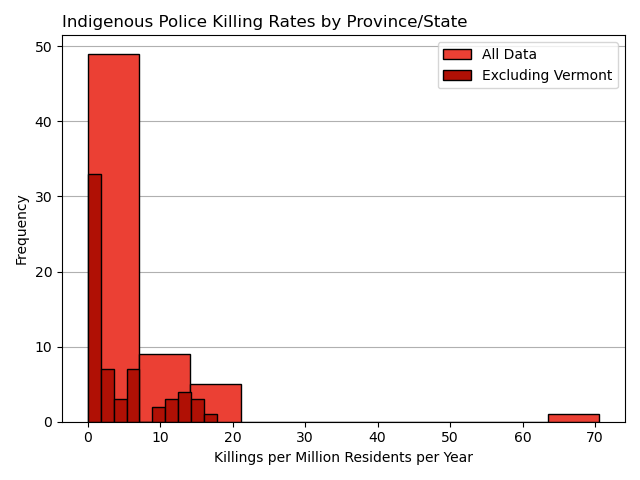

count    64.000000
mean      4.999049
std       9.850764
min       0.000000
25%       0.000000
50%       1.147056
75%       5.766422
max      70.603941
Name: Indigenous_Rate, dtype: float64


In [156]:

Data.ScaleData(scale=1e6)
Rate = 'Indigenous'
print(Data.Combined[Rate+'_Rate'].describe())
fig,ax=plt.subplots()
Data.Combined[Rate+'_Rate'].hist(color='#eb4034',
                                 edgecolor='k',bins=10,label='All Data',zorder=2)
# ax.set_title('Indigenous Police Killing Rates by State in US States')

Rate = 'Indigenous'
print(Data.Combined[Rate+'_Rate'].describe())
Data.Combined.loc[Data.Combined[Rate+'_Rate']<50,Rate+'_Rate'].hist(color='#b01005',
                                edgecolor='k',bins=10,label='Excluding Vermont',zorder=2)
ax.set_title('Indigenous Police Killing Rates by Province/State',loc='left')

ax.set_ylabel('Frequency')
ax.set_xlabel('Killings per Million Residents per Year')

ax.legend()
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('Content/Combined_Hist_by_Race.png')


# Data.Combined[Rate+'_Fraction'] = Data.Combined[Rate]/Data.Combined['Total']*100
# Data.Combined[[Rate+'_Rate',Rate+'_Killings',Rate,Rate+'_Fraction']].sort_values(Rate+'_Rate',ascending=False).round(3)[:5].reset_index()

# Classification Methods

We'll cover five classification methods

1) Equal Interval
* Data is split to bins of equal width regardless of distribution

2) Quantiles
* Data is split by percentiles

3) Natural Breaks
* Data is split using the Jenks algorithm

4) Standard Deviation
* Data is split to bins based on distance from the mean

5) Manual Breaks
* We define our own splits

# Equal Interval

* The simplest classification scheme is to just break the data into classes of equal sizes
    * e.g. The minimum is .3 and the maximum is 9.8, so we can split that into four bins 2.4 units wide


['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


<IPython.core.display.Javascript object>


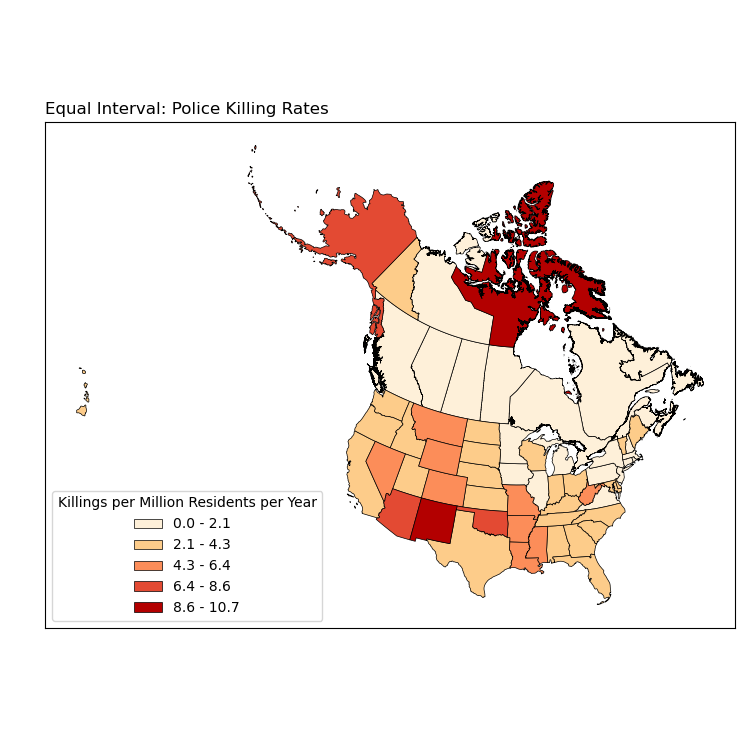

(-0.001, 2.14]
(2.14, 4.28]
(4.28, 6.42]
(6.42, 8.56]
(8.56, 10.7]


<IPython.core.display.Javascript object>


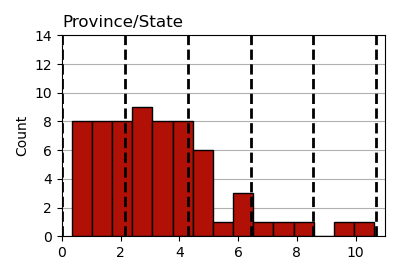

NL    (-0.001, 2.14]
NH    (-0.001, 2.14]
NJ    (-0.001, 2.14]
CT    (-0.001, 2.14]
MA    (-0.001, 2.14]
           ...      
AZ      (6.42, 8.56]
AK      (6.42, 8.56]
OK      (6.42, 8.56]
NU      (8.56, 10.7]
NM      (8.56, 10.7]
Name: Total_Rate_EB, Length: 64, dtype: category
Categories (5, interval[float64]): [(-0.001, 2.14] < (2.14, 4.28] < (4.28, 6.42] < (6.42, 8.56] < (8.56, 10.7]]
PE     0.334230
NL     0.367615
NS     0.413720
NB     0.447526
QC     0.596729
        ...    
AZ     6.863845
OK     7.677608
AK     8.177055
NM     9.749036
NU    10.630721
Name: Total_Rate, Length: 64, dtype: float64
[ 0.    2.14  4.28  6.42  8.56 10.7 ]


In [157]:

Data.ScaleData(scale=1e6)
Rate = 'Total'
n_classes=5
Data.Breaks(column=Rate+'_Rate',classes=n_classes,Manual_Bins=[0,1,2,5,10,15])

labels=Data.Combined[Rate+'_Rate_EB'].unique().sort_values()
colors = []
Grey = .85

colors=['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
Combined_Color = {key:value for key,value in zip(labels,colors)}

fig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []
for i,klass in enumerate(Data.Combined[Rate+'_Rate_EB'].unique().sort_values()):
    print(klass)
    try:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.EB_bins[i],1))+' - '+str(np.round(Data.EB_bins[i+1],1))}
        Data.Combined.loc[Data.Combined[Rate+'_Rate_EB']==klass].plot(
            ax=ax,
            **kwargs
                 )
        Combined_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass   

ax.legend(handles=(Combined_Patches), loc='lower left',ncol=1,title='Killings per Million Residents per Year')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Equal Interval: Police Killing Rates',loc='left')

plt.savefig('Content/EqualInterval_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k',zorder=2)


for v in Data.EB_bins:
    ax.axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')
ax.set_title('Province/State',loc='left')
plt.tight_layout()

plt.savefig('Content/EqualInterval_Hist.png')

print(Data.Combined[Rate+'_Rate_EB'].sort_values())
print(Data.Combined[Rate+'_Rate'].sort_values())
print(Data.EB_bins)

In [158]:
column='Total_Rate'
Data.Combined[column+'_EB'] = pd.cut(Data.Combined[column],
                bins=Data.EB_bins,#pd.interval_range(start=0,freq=2,end=10,closed='neither'),
#                 labels=labels,
                include_lowest=True,
                duplicates='drop'
                           )
# print(Data.Combined['Total_Rate'])
print(Data.Combined[column+'_EB'])
print(Data.EB_bins)

NL    (-0.001, 2.14]
PE    (-0.001, 2.14]
NS    (-0.001, 2.14]
NB    (-0.001, 2.14]
QC    (-0.001, 2.14]
           ...      
ME      (2.14, 4.28]
HI      (2.14, 4.28]
NH    (-0.001, 2.14]
AZ      (6.42, 8.56]
RI    (-0.001, 2.14]
Name: Total_Rate_EB, Length: 64, dtype: category
Categories (5, interval[float64]): [(-0.001, 2.14] < (2.14, 4.28] < (4.28, 6.42] < (6.42, 8.56] < (8.56, 10.7]]
[ 0.    2.14  4.28  6.42  8.56 10.7 ]


In [159]:
# Data.Combined_jenks
# Data.Combined['White_Rate_NB']
# Data.EB_bins

# Quantiles

<IPython.core.display.Javascript object>


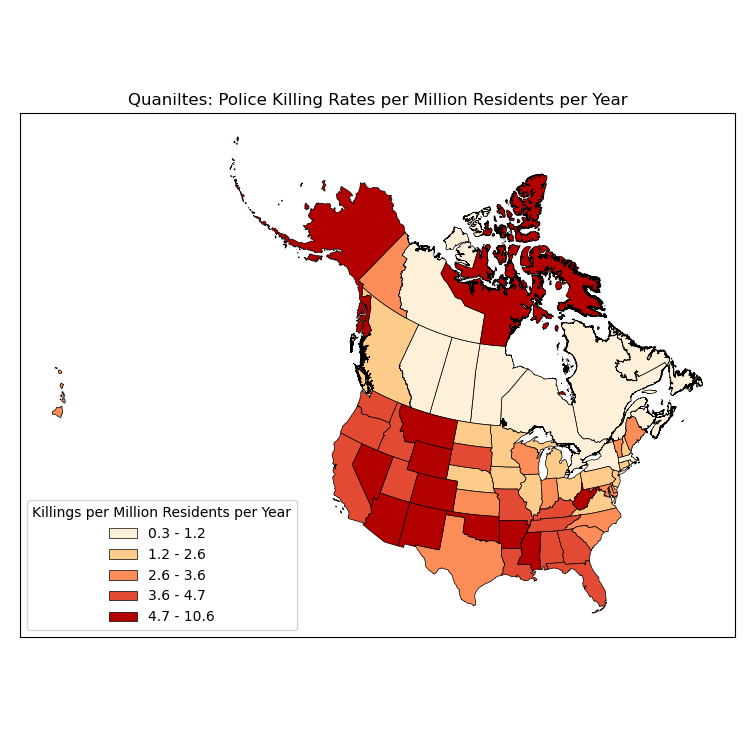

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


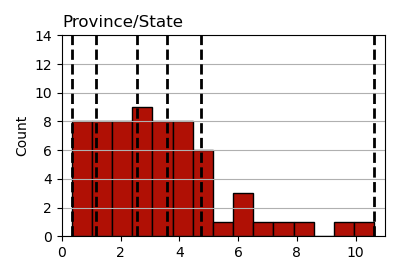

In [160]:

labels=Data.Combined[Rate+'_Rate_QB'].unique().sort_values()
# colors = []
Grey = .85

Combined_Color = {key:value for key,value in zip(labels,colors)}

fig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []

for i,klass in enumerate(Data.Combined[Rate+'_Rate_QB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':Combined_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.Combined[Rate+'_Rate'].quantile(i/Data.classes),1))+' - '+str(np.round(Data.Combined[Rate+'_Rate'].quantile((i+1)/Data.classes),1))}
    Data.Combined.loc[Data.Combined[Rate+'_Rate_QB']==klass].plot(
        ax=ax,
        **kwargs
             )
    Combined_Patches.append(mpatches.Patch(**kwargs))

    
ax.legend(handles=(Combined_Patches), loc='lower left',ncol=1,title='Killings per Million Residents per Year')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Quaniltes: Police Killing Rates per Million Residents per Year')

plt.tight_layout()
plt.savefig('Content/Quantile_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k')

for v in range(Data.classes+1):
    ax.axvline(Data.Combined[Rate+'_Rate'].quantile(v/Data.classes), color='k', linestyle='dashed', linewidth=2,label='Mean')
ax.grid(axis='x')

ax.set_xlim(0,11)

ax.set_ylim(0,14)

ax.set_ylabel('Count')

ax.set_title('Province/State',loc='left')

plt.tight_layout()

plt.savefig('Content/Quantiled_Hist.png')


# Natural Breaks

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


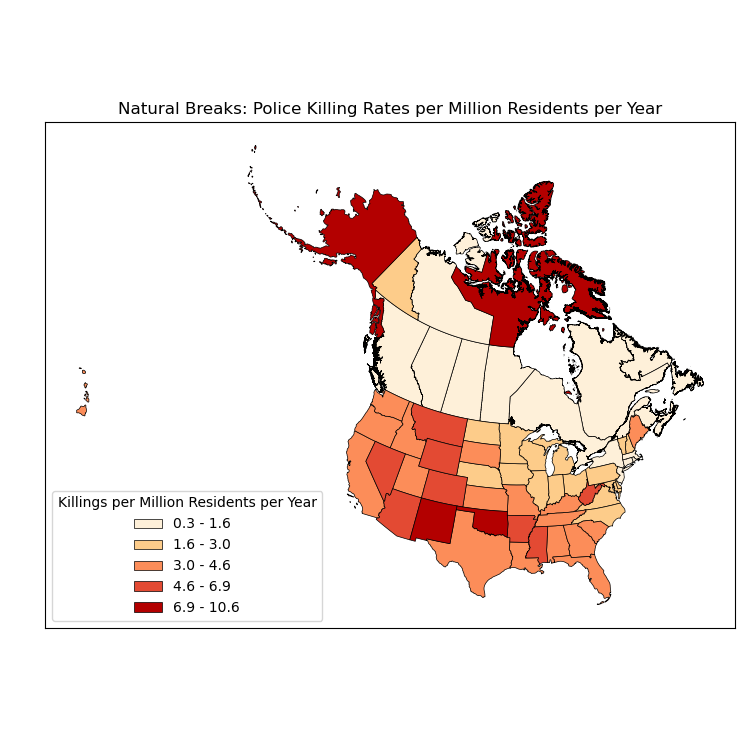

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


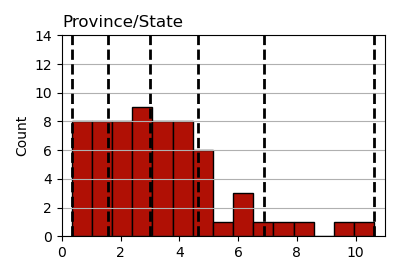

In [161]:

Rate = 'Total'
labels=Data.Combined[Rate+'_Rate_NB'].unique().sort_values()
# colors = []
Grey = .85
Combined_Color = {key:value for key,value in zip(labels,colors)}
fig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []
for i,klass in enumerate(Data.Combined[Rate+'_Rate_NB'].unique().sort_values()):
    try:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':str(np.round(Data.Combined_jenks[i],1))+' - '+str(np.round(Data.Combined_jenks[i+1],1))}
        Data.Combined.loc[Data.Combined[Rate+'_Rate_NB']==klass].plot(
            ax=ax,
            **kwargs
                 )
        Combined_Patches.append(mpatches.Patch(**kwargs))
    except:
        pass
    

ax.legend(handles=(Combined_Patches), loc='lower left',title='Killings per Million Residents per Year')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Natural Breaks: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/NaturalBreaks_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k')
for v0,v1 in zip(Data.Combined_jenks,Data.Combined_jenks):
    ax.axvline(v1, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')


ax.set_title('Province/State',loc='left')
plt.tight_layout()

plt.savefig('Content/NaturalBreaks_Hist.png')



# Manual Breaks

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<IPython.core.display.Javascript object>


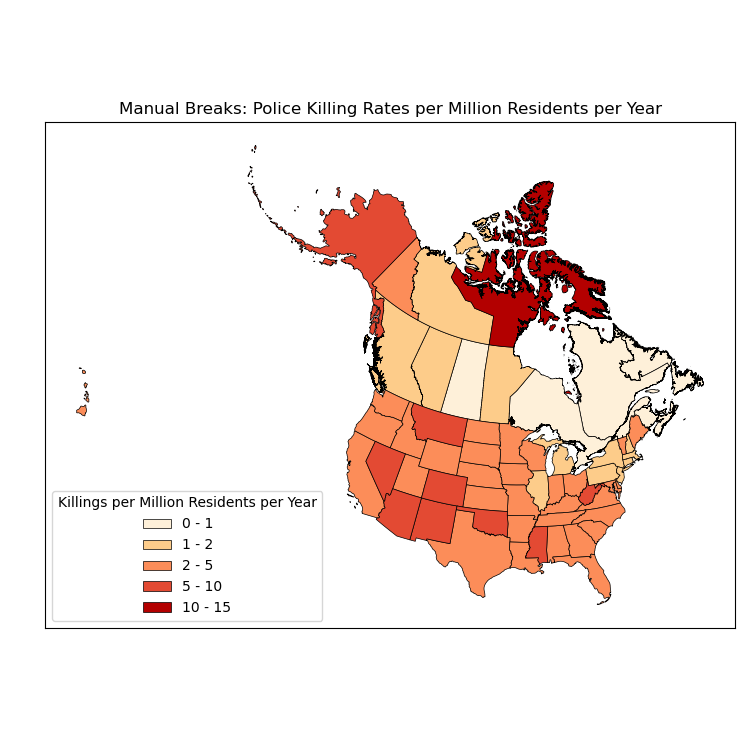

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


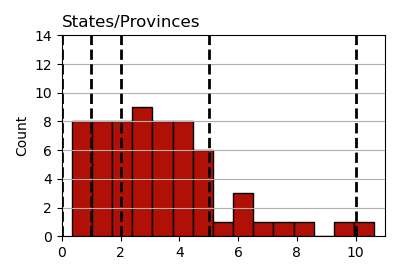

    Total_Rate  Total_Rate_MB
NL    0.367615  (-0.001, 1.0]
SK    0.956710  (-0.001, 1.0]
ON    0.667703  (-0.001, 1.0]
QC    0.596729  (-0.001, 1.0]
RI    0.698350  (-0.001, 1.0]
..         ...            ...
NV    6.042837    (5.0, 10.0]
AZ    6.863845    (5.0, 10.0]
CO    5.898645    (5.0, 10.0]
MT    5.908092    (5.0, 10.0]
NU   10.630721   (10.0, 15.0]

[64 rows x 2 columns]
[(-0.001, 1.0], (1.0, 2.0], (2.0, 5.0], (5.0, 10.0], (10.0, 15.0]]
Categories (5, interval[float64]): [(-0.001, 1.0] < (1.0, 2.0] < (2.0, 5.0] < (5.0, 10.0] < (10.0, 15.0]]


In [162]:

labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()

Combined_Color = {key:value for key,value in zip(labels,colors)}

ig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []
labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()

for i,klass in enumerate(Data.Combined[Rate+'_Rate_MB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':Combined_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':str(np.round(Data.Manual_Bins[i],1))+' - '+str(np.round(Data.Manual_Bins[i+1],1))}
#     print(Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].index)
    Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].plot(
        ax=ax,
        **kwargs
             )
    Combined_Patches.append(mpatches.Patch(**kwargs))
#     except:
#         pass
    
#     print(Combined_Patches)
ax.legend(handles=(Combined_Patches), loc='lower left',title='Killings per Million Residents per Year')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Manual Breaks: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/ManualBreaks_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k')

for v in Data.Manual_Bins:
    ax.axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')


ax.set_title('States/Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/ManualBreaks_Hist.png')

print(Data.Combined[[Rate+'_Rate',Rate+'_Rate_MB']].sort_values(by=Rate+'_Rate_MB'))
print(Data.Combined[Rate+'_Rate_MB'].unique().sort_values())

# Standard Deviation

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


<IPython.core.display.Javascript object>


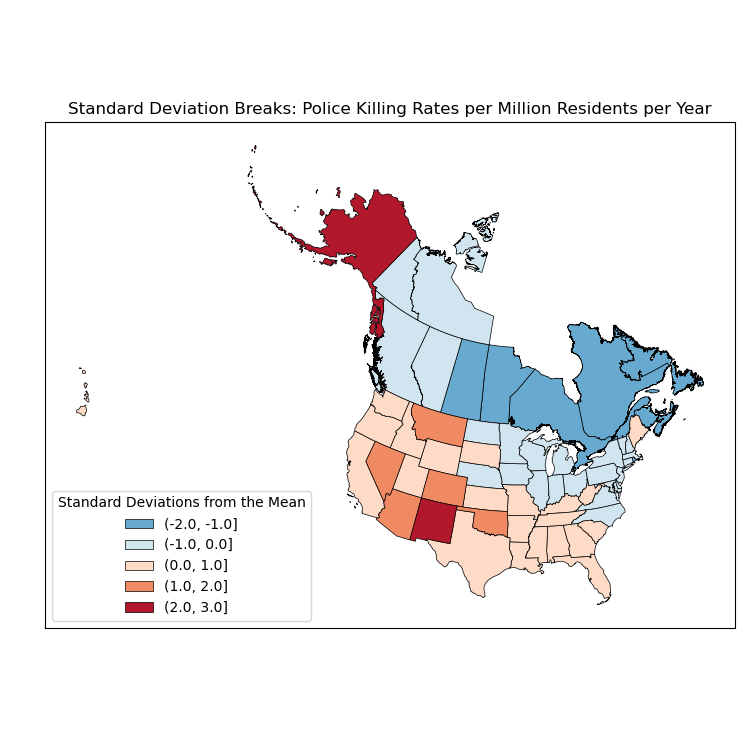

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


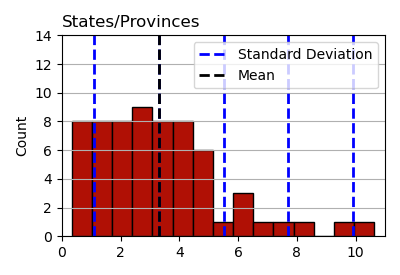

NL    (-2.0, -1.0]
SK    (-2.0, -1.0]
MB    (-2.0, -1.0]
ON    (-2.0, -1.0]
RI    (-2.0, -1.0]
          ...     
MT      (1.0, 2.0]
NV      (1.0, 2.0]
NM      (2.0, 3.0]
AK      (2.0, 3.0]
NU      (3.0, 4.0]
Name: Total_Rate_STD, Length: 64, dtype: category
Categories (10, interval[float64]): [(-5.0, -4.0] < (-4.0, -3.0] < (-3.0, -2.0] < (-2.0, -1.0] ... (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0] < (4.0, 5.0]]


In [163]:
import pandas as pd
Rate = 'Total'
labels=pd.cut(np.arange(-2,3.5),np.arange(-2,3.5))[1:]

colors_hex = []
colors_rgb = []
n_classes_STD=labels.shape[0]

Colors = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf']
Combined_Color = {key:value for key,value in zip(labels,Colors[::-1])}
# print(Combined_Color)
Combined_Patches=[]
fig,ax=plt.subplots(figsize=(7.5,7.5))
for klass in labels:
    kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':klass}
    Combined_Patches.append(mpatches.Patch(**kwargs))

for i,klass in enumerate(Data.Combined[Rate+'_Rate_STD'].unique().sort_values()):
    try:
        kwargs = {'facecolor':Combined_Color[klass],
                 'edgecolor':'black',
                 'linewidth':.5,
                 'label':klass}## for c in range(n_classes_STD):
        Data.Combined.loc[Data.Combined[Rate+'_Rate_STD']==klass].plot(
            ax=ax,
            **kwargs
                 )
    except:
        pass
ax.legend(handles=(Combined_Patches), loc='lower left',title='Standard Deviations from the Mean')
plt.tight_layout()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Standard Deviation Breaks: Police Killing Rates per Million Residents per Year')

plt.savefig('Content/STDBreaks_Map.png',bbox_inches='tight')

fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color='#b01005',edgecolor='k')

for v in range(-4,5):
    if v == 4:
        ax.axvline(Data.Combined[Rate+'_Rate'].mean()+Data.Combined[Rate+'_Rate'].std()*v,
               color='b', linestyle='dashed', linewidth=2,label='Standard Deviation')
    else:
        ax.axvline(Data.Combined[Rate+'_Rate'].mean()+Data.Combined[Rate+'_Rate'].std()*v,
               color='b', linestyle='dashed', linewidth=2)
    

ax.axvline(Data.Combined[Rate+'_Rate'].mean(), color='k', linestyle='dashed', linewidth=2,label='Mean')
ax.legend()
ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')
ax.set_title('States/Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/STDBreaks_Hist.png')

print(Data.Combined[Rate+'_Rate_STD'].sort_values())

# Ratio to Ordinal

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


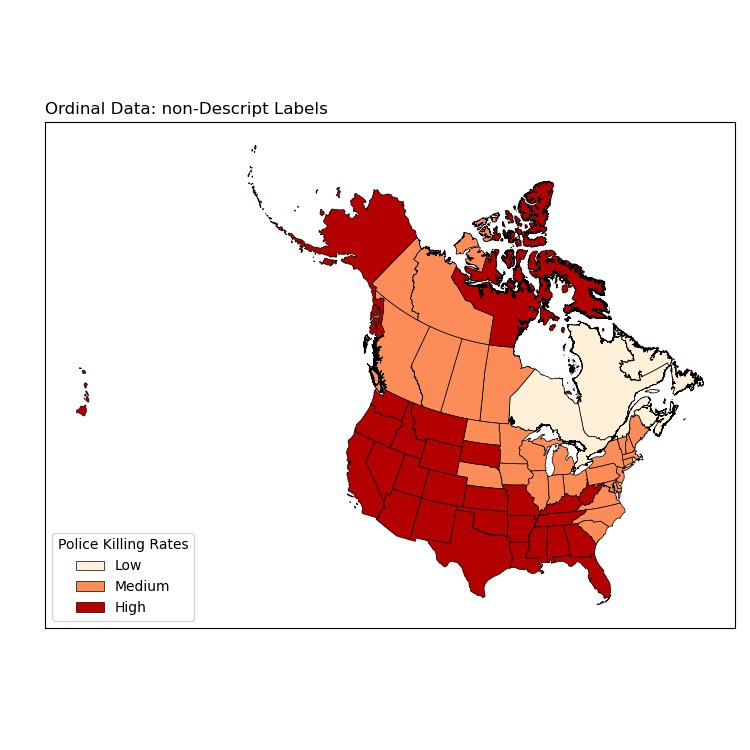

['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Visible minority, n.i.e_Killings', 'Visible minority, n.i.e_Rate', 'Visible minority, n.i.e', 'South Asian_Killings', 'South Asian_Rate', 'South Asian', 'Arab_Killings', 'Arab_Rate', 'Arab', 'Latin American_Killings', 'Latin American_Rate', 'Latin American', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country'] ['Black_Killings', 'Black_Rate', 'Black', 'Asian_Killings', 'Asian_Rate', 'Asian', 'Indigenous_Killings', 'Indigenous_Rate', 'Indigenous', 'Unknown_Killings', 'Unknown_Rate', 'White_Killings', 'White_Rate', 'White', 'Hispanic_Killings', 'Hispanic_Rate', 'Hispanic', 'Pacific Islander_Killings', 'Pacific Islander_Rate', 'Pacific Islander', 'Total_Killings', 'Total_Rate', 'Total', 'geometry', 'Country']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


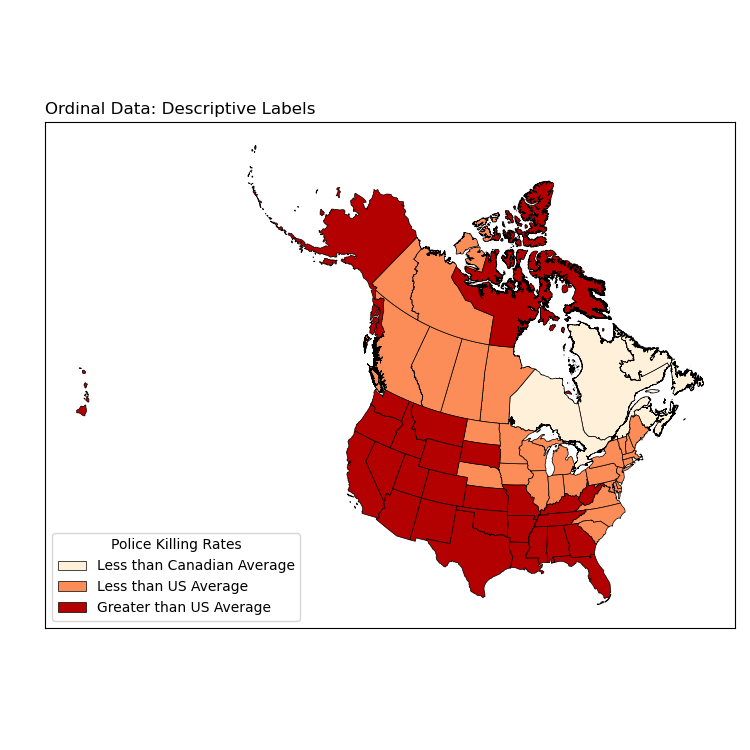

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


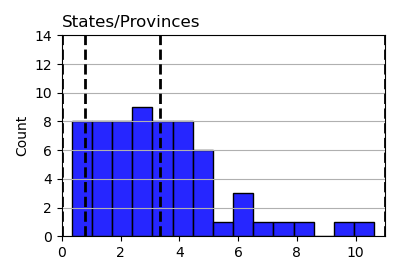

In [164]:
# CA
Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=3,
            Manual_Bins=[0,CA_Rate,
                         US_Rate,11],
            labels=['Low',
                    'Medium',
                    'High'])


colors=['#fef0d9','#fc8d59','#b30000']
Rate = 'Total'
labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()
# colors = []
# Grey = .85
# for c in range(n_classes):
#     colors.append(matplotlib.colors.to_hex([Grey+(c/(n_classes-1)*(1-Grey)),Grey-(c/(n_classes-1)*Grey),Grey-(c/(n_classes-1)*Grey)]))
Combined_Color = {key:value for key,value in zip(labels,colors)}
# print(Combined_Color)

# import matplotlib
fig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []

labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()
Combined_Color = {key:value for key,value in zip(labels,colors)}
for i,klass in enumerate(Data.Combined[Rate+'_Rate_MB'].unique().sort_values()):
#     try:
    kwargs = {'facecolor':Combined_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}#str(np.round(Data.Manual_Breaks[i],1))+' - '+str(np.round(Data.Manual_Breaks[i+1],1))}
    Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].plot(
        ax=ax,
        **kwargs
             )
    Combined_Patches.append(mpatches.Patch(**kwargs))
    

ax.legend(handles=(Combined_Patches), loc='lower left',title='Police Killing Rates')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Ordinal Data: non-Descript Labels',loc='Left')

plt.savefig('Content/Ordinal_Map_Bad_Labels.png',bbox_inches='tight')


Data.ScaleData(scale=1e6)
Data.Breaks(column=Rate+'_Rate',classes=3,
            Manual_Bins=[0,CA_Rate,
                         US_Rate,11],
            labels=['Less than Canadian Average',
                    'Less than US Average',
                    'Greater than US Average'])


# colors=['#fef0d9','#fc8d59','#b30000']
Rate = 'Total'
labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()
Combined_Color = {key:value for key,value in zip(labels,colors)}


fig,ax=plt.subplots(figsize=(7.5,7.5))
Combined_Patches = []

labels=Data.Combined[Rate+'_Rate_MB'].unique().sort_values()
Combined_Color = {key:value for key,value in zip(labels,colors)}
for i,klass in enumerate(Data.Combined[Rate+'_Rate_MB'].unique().sort_values()):
    kwargs = {'facecolor':Combined_Color[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
    Data.Combined.loc[Data.Combined[Rate+'_Rate_MB']==klass].plot(
        ax=ax,
        **kwargs
             )
    Combined_Patches.append(mpatches.Patch(**kwargs))

ax.legend(handles=(Combined_Patches), loc='lower left',title='Police Killing Rates')

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Ordinal Data: Descriptive Labels',loc='Left')

plt.savefig('Content/Ordinal_Map.png',bbox_inches='tight')
fig,ax = plt.subplots(1,1,figsize=(4,2.75),sharex=True)

Data.Combined[Rate+'_Rate'].hist(ax=ax,bins=15,color=[0,0,1,Grey],edgecolor='k')

for v in Data.Manual_Bins:
    ax.axvline(v, color='k', linestyle='dashed', linewidth=2,label='Mean')

ax.grid(axis='x')
ax.set_xlim(0,11)
ax.set_ylim(0,14)
ax.set_ylabel('Count')


ax.set_title('States/Provinces',loc='left')
plt.tight_layout()

plt.savefig('Content/Ordinal_Hist.png')


In [165]:
# print(Data.Combined.columns)#.sort_values())
# print(Data.CA.append(Data.US
# Categories = [v for v in Data.CA_PoliceKillings.RACE.unique()]
# for c in Data.US_PoliceKillings.RACE.unique():
#     if c not in Data.CA_PoliceKillings.RACE.unique():
#         Categories.append(c)
print(Data.US.columns)
print(Data.US_PoliceKillings.RACE.unique())

Index([                  'STATEFP',                   'STATENS',
                           'GEOID',                      'NAME',
                            'LSAD',                     'ALAND',
                          'AWATER',                  'geometry',
                           'State',                     'White',
                           'Black',                'Indigenous',
                           'Asian',          'Pacific Islander',
                 'Some other race',                  'Hispanic',
                           'Total',                     'Mixed',
                  'Total_Killings',            'Asian_Killings',
                  'Black_Killings',         'Hispanic_Killings',
                       'Hispanic ',       'Indigenous_Killings',
       'Pacific Islander_Killings',          'Unknown_Killings',
                    'Unknown Race',            'White_Killings',
                              2013,                        2014,
                         

# Categorical

In [166]:
All = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.CA_PoliceKillings.groupby(['PROV','RACE']).count()['AGE'].unstack().T
Data.CA['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.CA.loc[Data.CA.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.CA['Top'])


All = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max1 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().max(axis=1)
Max2 = Data.US_PoliceKillings.groupby(['State','RACE']).count()['AGE'].unstack().T
Data.US['Top']=''
for v,i in zip(Max1,Max1.index):
    Data.US.loc[Data.US.index == i,'Top']=Max2.loc[Max2[i]==v].index.values[0]
# print(Data.US['Top'])


R = ['White','Black','Indigenous','Latin American','Hispanic','Pacific Islander']
Tempp = Data.Combined.copy()
for r in R:
    Tempp.loc[((Tempp[r]/Tempp['Total']<=.025)&(Tempp[r+'_Killings']<=2)),r+'_Rate']=np.nan
#     Tempp.loc[Tempp[r]<=5e3,r+'_Rate']=np.nan

Max = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']].max(axis=1)
Temp = Tempp[['White_Rate','Black_Rate','Indigenous_Rate','Latin American_Rate','Hispanic_Rate','Pacific Islander_Rate']]
# print(Temp.loc[Temp==Max])
Data.Combined['Top']=''
for index,row in Temp.iterrows():
#     print()
    Data.Combined.loc[Data.Combined.index==index,'Top']=row.loc[row==Max[index]].index.values[0].split('_')[0]
# print(Max
# print(Data.Combined['Top'])
# print(Data.Combined[['White_Rate','Black_Rate','Indigenous_Rate']])
print(Data.Combined[['Pacific Islander','Pacific Islander_Rate','Black_Rate','Pacific Islander_Killings','Top']].sort_values(by='Pacific Islander').dropna())

    Pacific Islander  Pacific Islander_Rate  Black_Rate  \
ID            2763.0              44.539511   10.191525   
OK            3859.0              31.889782   23.955469   
MI            3907.0              31.497996    4.290542   
PA            5008.0              24.573217    5.513846   
MO            7385.0              33.327737   14.152625   
AK            7958.0              15.464020   19.536083   
NC           10218.0              12.043714    4.706489   
UT           29362.0               8.382445   27.438722   
WA           53924.0              11.410751   13.073469   
HI          144971.0              20.373068    4.344666   
CA          155739.0               7.901853   11.046193   

    Pacific Islander_Killings               Top  
ID                        1.0        Indigenous  
OK                        1.0             Black  
MI                        1.0             Black  
PA                        1.0             Black  
MO                        2.0            

['White' 'Indigenous']
['Black' 'White' 'Hispanic' 'Pacific Islander']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


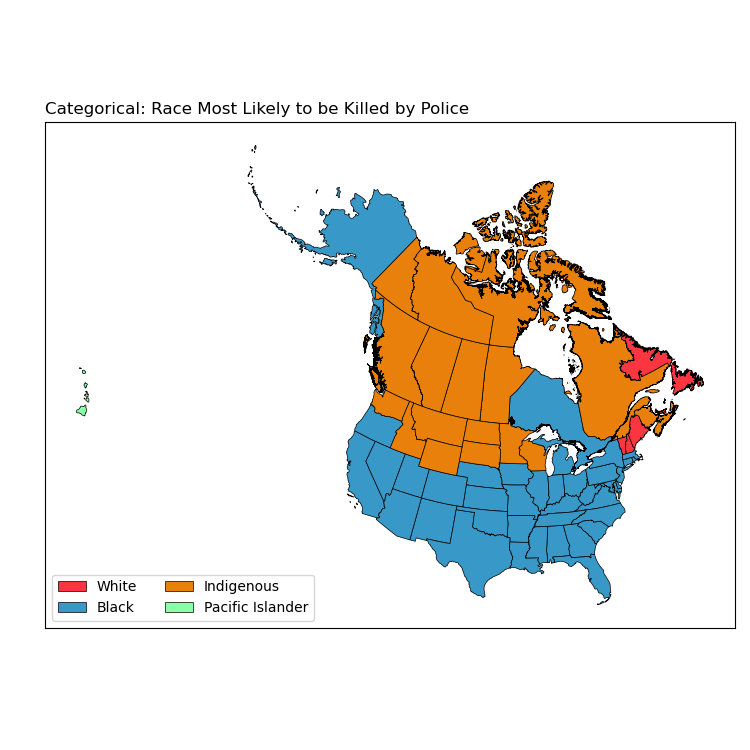

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


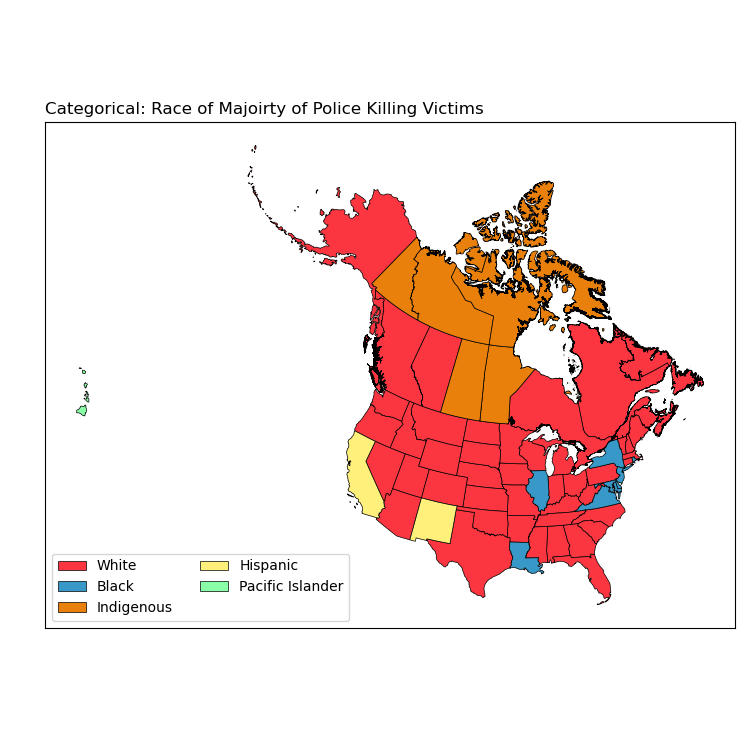

In [167]:
print(Data.CA['Top'].unique())
print(Data.US['Top'].unique())
RaceColor={'White':'#FB3640',
           'Black':'#3899C9',
           'Indigenous':'#E8800B',
           'Hispanic':'#FFF07C',
           'Pacific Islander':'#89FFA7',}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
   #str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.Combined.loc[Data.Combined['Top']==klass].count().Total_Killings>0:
        kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}
        Data.Combined.loc[Data.Combined['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
        CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Categorical: Race Most Likely to be Killed by Police',loc='left')

plt.savefig('Content/HighestRateRace_Map.png',bbox_inches='tight')

# RaceColor={'White':'#FB3640',
#            'Black':'#3899C9',
#            'Indigenous':'#E8800B',
#            'Hispanic':'#FFF07C',
#            'Pacific Islander':'#89FFA7'}

fig,ax=plt.subplots(figsize=(7.5,7.5))
CA_Patches = []#[matplotlib.text.Annotation('Canada',(0,0))]

# CA_Patches.append(mpatches.Patch(**{'facecolor':'None',
#                  'edgecolor':'None',
#                  'linewidth':.5,'label':'Canada\n2000-2020'}))
for klass in RaceColor.keys():
#     try:?
    kwargs = {'facecolor':RaceColor[klass],
             'edgecolor':'black',
             'linewidth':.5,
             'label':klass}#str(np.round(Data.CA_STD_bins[i],1))+' - '+str(np.round(Data.CA_STD_bins[i+1],1))}
    if Data.CA.loc[Data.CA['Top']==klass].count().Total_Killings>0:
        Data.CA.loc[Data.CA['Top']==klass].plot(
        ax=ax,
        **kwargs
             )
    if Data.US.loc[Data.US['Top']==klass].count()['State']>0:
    
        Data.US.loc[Data.US['Top']==klass].plot(
            ax=ax,
            **kwargs
                 )
    CA_Patches.append(mpatches.Patch(**kwargs))


ax.legend(handles=(CA_Patches), loc='lower left',ncol=2)

plt.tight_layout()
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Categorical: Race of Majoirty of Police Killing Victims',loc='left')

plt.savefig('Content/MostNumerousRace_Map.png',bbox_inches='tight')
